# Figures for the manuscript

In [1]:
%load_ext autoreload

In [2]:
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import xarray as xr
from tqdm import tqdm
from pathlib import Path

from LAPM.discrete_linear_autonomous_pool_model import DiscreteLinearAutonomousPoolModel as DLAPM
from CompartmentalSystems.discrete_model_run import DiscreteModelRun as DMR
import CompartmentalSystems.helpers_reservoir as hr

from BFCPM import utils
from BFCPM import DATA_PATH, FIGS_PATH, Q_, zeta_dw
from BFCPM.trees.single_tree_allocation import allometries
from BFCPM.trees.single_tree_params import species_params

%autoreload 2

In [3]:
# set plotting properties

mpl.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 16
MEDIUM_SIZE = 17
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load available simulations and sort them

In [4]:
all_sims_path = DATA_PATH.joinpath("simulations")

#sim_date = "2023-05-20" # differenct emergency strategies
#sim_date = "2023-06-08" # corrected wood density
#sim_date = "2023-06-19" # automatic thinning stand to SBA=18 on emergency cutting
sim_date = "2023-07-26" # publication

# path to place the figures for the publication
pub_figs_path = FIGS_PATH.joinpath(f"{sim_date}")
pub_figs_path.mkdir(exist_ok=True, parents=True)

print(pub_figs_path)

spinup_length = 160

sim_cohort_path = all_sims_path.joinpath(sim_date)
print(sim_cohort_path)

/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26
/mnt/c/Users/hrme0001/GitHub/BFCPM/data/simulations/2023-07-26


In [5]:
dss = dict()
dmrs = dict()
dmrs_eq = dict()
dss_long = dict()

dss_benchmarking = dict()

In [6]:
# reconcile filenames and simulation names
eligible_sim_names = {
    "mixed-aged_pine_N1500": "mixed-aged_pine",
    "even-aged_pine": "even-aged_pine",
    "even-aged_spruce": "even-aged_spruce",
    "even-aged_mixed": "even-aged_mixed",
}

In [7]:
sim_names = list()
for p in sim_cohort_path.iterdir():
    if (p.suffix == ".nc") and (str(p).find("_long") == -1):
        file_sim_name = p.stem
        if file_sim_name in eligible_sim_names.keys():
            sim_name = eligible_sim_names[file_sim_name]
            print(len(sim_names), sim_name)
            sim_names.append(sim_name)
            dss[sim_name] = xr.open_dataset(str(p))
        
            dmr_path = sim_cohort_path.joinpath(p.stem + ".dmr")
            dmrs[sim_name] = DMR.load_from_file(dmr_path)
    
            dmr_eq_path = sim_cohort_path.joinpath(p.stem + ".dmr_eq")
            dmrs_eq[sim_name] = DLAPM.load_from_file(dmr_eq_path)
        
            ds_long_path = sim_cohort_path.joinpath(p.stem + "_long.nc")
            dss_long[sim_name] = xr.open_dataset(str(ds_long_path))

0 even-aged_mixed
1 even-aged_pine
2 even-aged_spruce
3 mixed-aged_pine


In [8]:
# add single-tree benchmarking simulations
sim_names_benchmarking = list()
for p in sim_cohort_path.joinpath("benchmarking").iterdir():
    if (p.suffix == ".nc") and (str(p).find("_long") == -1):
        sim_name = p.stem
        print(sim_name)
        dss_benchmarking[sim_name] = xr.open_dataset(str(p))

single_pine
single_spruce


In [9]:
sim_names = [sim_names[k] for k in [3, 1, 2, 0]]
#sim_names = [sim_names[k] for k in [2, 0, 1, 3]]

nr_spinup_trees = 4
[print(f"{k}: {sim_name}") for k, sim_name in enumerate(sim_names)];

0: mixed-aged_pine
1: even-aged_pine
2: even-aged_spruce
3: even-aged_mixed


## State after spinup

In [10]:
def round_arr(arr: np.ndarray, decimals: int) -> np.ndarray:
    """Round array to `decimals` decimals."""
    try:
        return round(float(arr), decimals)
    except TypeError:
        return np.array([round(x, decimals) for x in arr])

In [11]:
key = sim_names[0]

dbhs = dss[key].DBH.isel(time=0)
print("dbh:", round_arr(dbhs.data, 1), "cm")

Hs = dss[key].height.isel(time=0)
print("H:", round_arr(Hs.data, 1), "m")

tree_biomasses = dss[key].stocks.isel(entity=range(nr_spinup_trees), time=0).sum(dim="pool") * 1e-03
print("tree biomass:", round_arr(tree_biomasses.data, 3), "total:", round_arr(sum(tree_biomasses.data), 1), "kgC/m^2")

soil_biomass = dss[key].stocks.sel(entity="soil", time=0).sum(dim="pool") * 1e-03
print("soil biomass:", round_arr(soil_biomass.data, 1),"kgC/m^2")

#forest_stand_biomass = dss[key].stocks.isel(entity=list(range(nr_spinup_trees)) + [8], time=0).sum(dim=["entity", "pool"]) * 1e-03
forest_stand_biomass = tree_biomasses.sum() + soil_biomass
print("forest stand biomass:", round_arr(forest_stand_biomass.data, 1), "kgC/m^2")

WP_biomass = dss[key].stocks.sel(entity="wood_product", time=0).sum(dim="pool") * 1e-03
print("WP biomass:", round_arr(WP_biomass.data, 1), "kgC/m^2")

total_biomass = dss[key].stocks.isel(time=0).sum(dim=["entity", "pool"]) * 1e-03
print("total biomass:", round_arr(total_biomass.data, 1), "kgC/m^2")

dbh: [10.5  6.3  3.3 22.7] cm
H: [15.  10.7  6.1 21.2] m
tree biomass: [0.85  0.248 0.057 5.424] total: 6.6 kgC/m^2
soil biomass: 5.5 kgC/m^2
forest stand biomass: 12.1 kgC/m^2
WP biomass: 2.6 kgC/m^2
total biomass: 14.7 kgC/m^2


## Show the mean diameter at breast height, the stand basal area, the tree C stock, and the stand's total C stock

mixed-aged_pine total carbon stock 13.847516512226107 gC/m^2
even-aged_pine total carbon stock 17.806788930278415 gC/m^2
even-aged_spruce total carbon stock 16.312801182105577 gC/m^2
even-aged_mixed total carbon stock 18.01256334108489 gC/m^2
Total tree carbon (40 yr) mixed-aged_pine 5.76460390692793 kilog_carbon / meter ** 2
Total tree carbon (40 yr) even-aged_pine 5.291673797721138 kilog_carbon / meter ** 2
Total tree carbon (40 yr) even-aged_spruce 6.74756247802453 kilog_carbon / meter ** 2
Total tree carbon (40 yr) even-aged_mixed 6.941932054324447 kilog_carbon / meter ** 2


'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/dbh_sba_and_C_stocks.png'

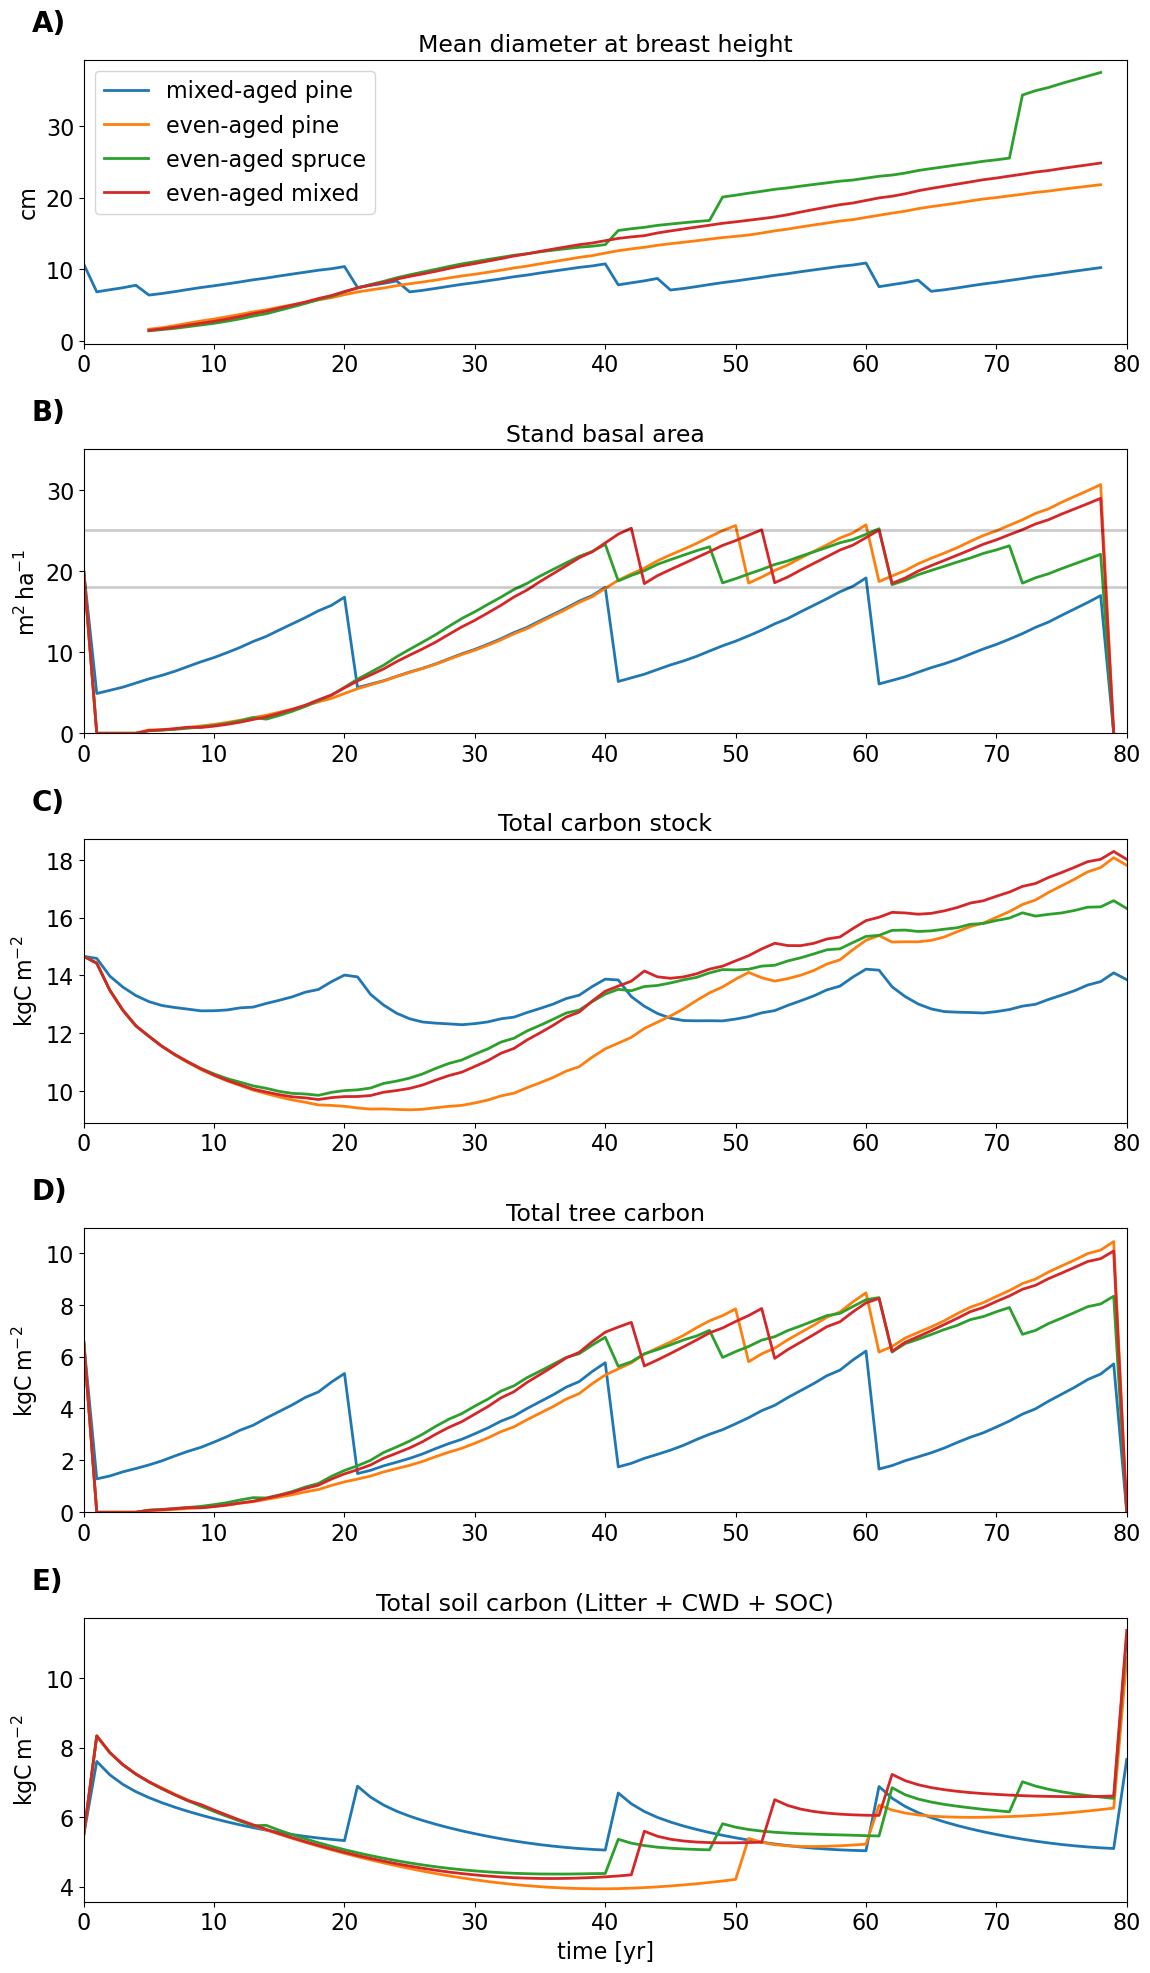

In [12]:
fig, axes = plt.subplots(figsize=(12, 4*5), nrows=5)
axes_list = axes

ax0 = axes[0]
axes = iter(axes)
panel_names = iter(string.ascii_uppercase[:len(axes_list)])
colors = dict()
colors_list = list()

ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Mean diameter at breast height")
for sim_name in sim_names:
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data
    N_per_m2 = ds.N_per_m2.sel(tree=tree_names)
    
    DBH = ds.DBH.sel(tree=tree_names).weighted(N_per_m2).mean(dim="tree")
    DBH = Q_(DBH.data, ds.DBH.attrs["units"])
    l, = ax.plot(ds.time, DBH, label=sim_name.replace("_", " "))
    colors[sim_name] = l.get_c()
    colors_list.append(l.get_c())

ax.set_ylabel("cm")
ax.legend()
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

  
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Stand basal area")
for sim_name in sim_names:
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data
    
    sba = ds.stand_basal_area
    sba = Q_(sba.data, sba.attrs["units"])
    l, = ax.plot(ds.time, sba, label=sim_name.replace("_", " "))
           
ax.set_ylabel(r"m$^2\,$ha$^{-1}$")
ax.set_ylim([0, 35])
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.axhline(18, color="black", alpha=0.2)
ax.axhline(25, color="black", alpha=0.2)


ax = next(axes)
panel_name = next(panel_names)
for sim_name in sim_names:
    ds = dss[sim_name]
    var = ds.total_C_stock / 1000
    var.plot(ax=ax, label=sim_name.replace("_", " "))
    print(sim_name, "total carbon stock", var[-1].data, "gC/m^2")

ax.set_title("Total carbon stock")
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_xlabel("")


ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Total tree carbon")
for sim_name in sim_names:
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data
    
    tree_biomass = ds.tree_biomass_tree.sel(tree=tree_names).sum(dim="tree")
    tree_biomass = Q_(tree_biomass.data, ds.tree_biomass_tree.attrs["units"]).to("kgC/m^2")
    l, = ax.plot(ds.time, tree_biomass, label=sim_name.replace("_", " "))
    print("Total tree carbon (40 yr)", sim_name, tree_biomass[40])
    
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


ax = next(axes)
panel_name = next(panel_names)
for sim_name in sim_names:
    ds = dss[sim_name]
    var = ds.stocks.sel(entity="soil").sum(dim="pool") / 1000
    var.plot(ax=ax, label=sim_name)

ax.set_title("Total soil carbon (Litter + CWD + SOC)")
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


ax0.legend()
for ax in axes_list:
    ax.set_xlim([0, 80])
    
ax.set_xlabel("time [yr]")
    
fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("dbh_sba_and_C_stocks.png"))
fig.savefig(filename, dpi=500)
filename

### Abstract: Even-aged strategies superior in C stocks at the end of the rotation

In [13]:
base_name = sim_names[0]

ds_base = dss[base_name]
for sim_name, ds in dss.items():
    if sim_name != base_name:
        x = (ds.stocks.isel(time=-1).sum(dim=["entity", "pool"]) / ds_base.stocks.isel(time=-1).sum(dim=["entity", "pool"]) * 100).data
        print(sim_name, round_arr(x, 1), "%")

even-aged_mixed 130.1 %
even-aged_pine 128.6 %
even-aged_spruce 117.8 %


### Overyielding in wood productivity


even-aged_pine WP_S pine 3.7974104183604456 [4 5 6 7]

even-aged_spruce WP_S spruce 1.2310124816915309 [4 5 6 7]

even-aged_mixed WP_S pine 1.769641759554201 [4 5]
even-aged_mixed WP_S spruce 1.0376023398949477 [6 7]

even-aged_pine WP_L pine 4.5692353014236415 [4 5 6 7]

even-aged_spruce WP_L spruce 4.290855948946334 [4 5 6 7]

even-aged_mixed WP_L pine 2.792248813304132 [4 5]
even-aged_mixed WP_L spruce 2.302424171181052 [6 7]


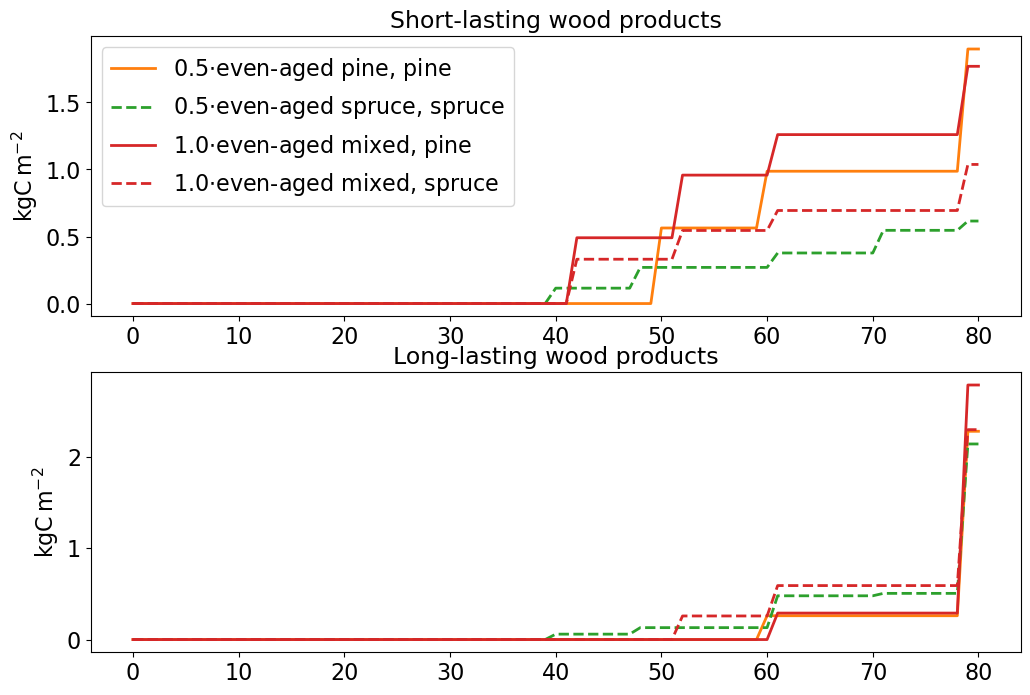

In [14]:
fig, axes = plt.subplots(figsize=(12, 4*2), nrows=2)

pools_to = ["WP_S", "WP_L"]
titles = ["Short-lasting wood products", "Long-lasting wood products"]

for ax, pool_to, title in zip(axes, pools_to, titles):
    ax.set_title(title)
    for sim_name in ["even-aged_pine", "even-aged_spruce", "even-aged_mixed"]:
        ds = dss[sim_name]
        color = colors[sim_name]
        z = 0
        print()
        for species, ls in zip(["pine", "spruce"], ["-", "--"]):
            species_entity_nrs = ds.tree_entity_nrs[ds.species.data==species]
            species_entity_nrs = species_entity_nrs[species_entity_nrs >= nr_spinup_trees]
            if len(species_entity_nrs) > 0:
                f = 1 / (1 + int(sim_name != "even-aged_mixed"))
#                f=1
                y = ds.internal_fluxes.isel(entity_from=species_entity_nrs).sel(entity_to="wood_product", pool_to=pool_to).sum(dim=["tree_entity_nrs", "pool_from"]).cumsum(dim="time")
#                y = ds.internal_fluxes.isel(entity_from=[4,5,6,7]).sel(entity_to="wood_product", pool_to=pool_to).sum(dim=["entity_from", "pool_from"]).cumsum(dim="time")
                print(sim_name, pool_to, species, y.isel(time=-1).data * 1e-03, species_entity_nrs.data)
                y = Q_(y.data, ds.stocks.attrs["units"]).to("kgC/m^2")
                ax.plot(ds.time, f * y, label=f"{f}$\\cdot${sim_name.replace('_', ' ')}, {species}", ls=ls, c=color)
                
                z += y[-1]

#        print("Z", sim_name, pool_to, z)
    ax.set_ylabel(r"kgC$\,$m$^{-2}$")
        
axes[0].legend();

WP_S:, even-aged mixed: 3.997316996808034 kilog_carbon / meter ** 2, theoretical mix: 3.704284347384873 kilog_carbon / meter ** 2, overyielding:  7.910641353168102%
WP_L:, even-aged mixed: 7.447182357259102 kilog_carbon / meter ** 2, theoretical mix: 6.782554997958906 kilog_carbon / meter ** 2, overyielding:  9.799070696812695%
['WP_S', 'WP_L']:, even-aged mixed: 11.444499354067135 kilog_carbon / meter ** 2, theoretical mix: 10.486839345343778 kilog_carbon / meter ** 2, overyielding:  9.132017543003212%


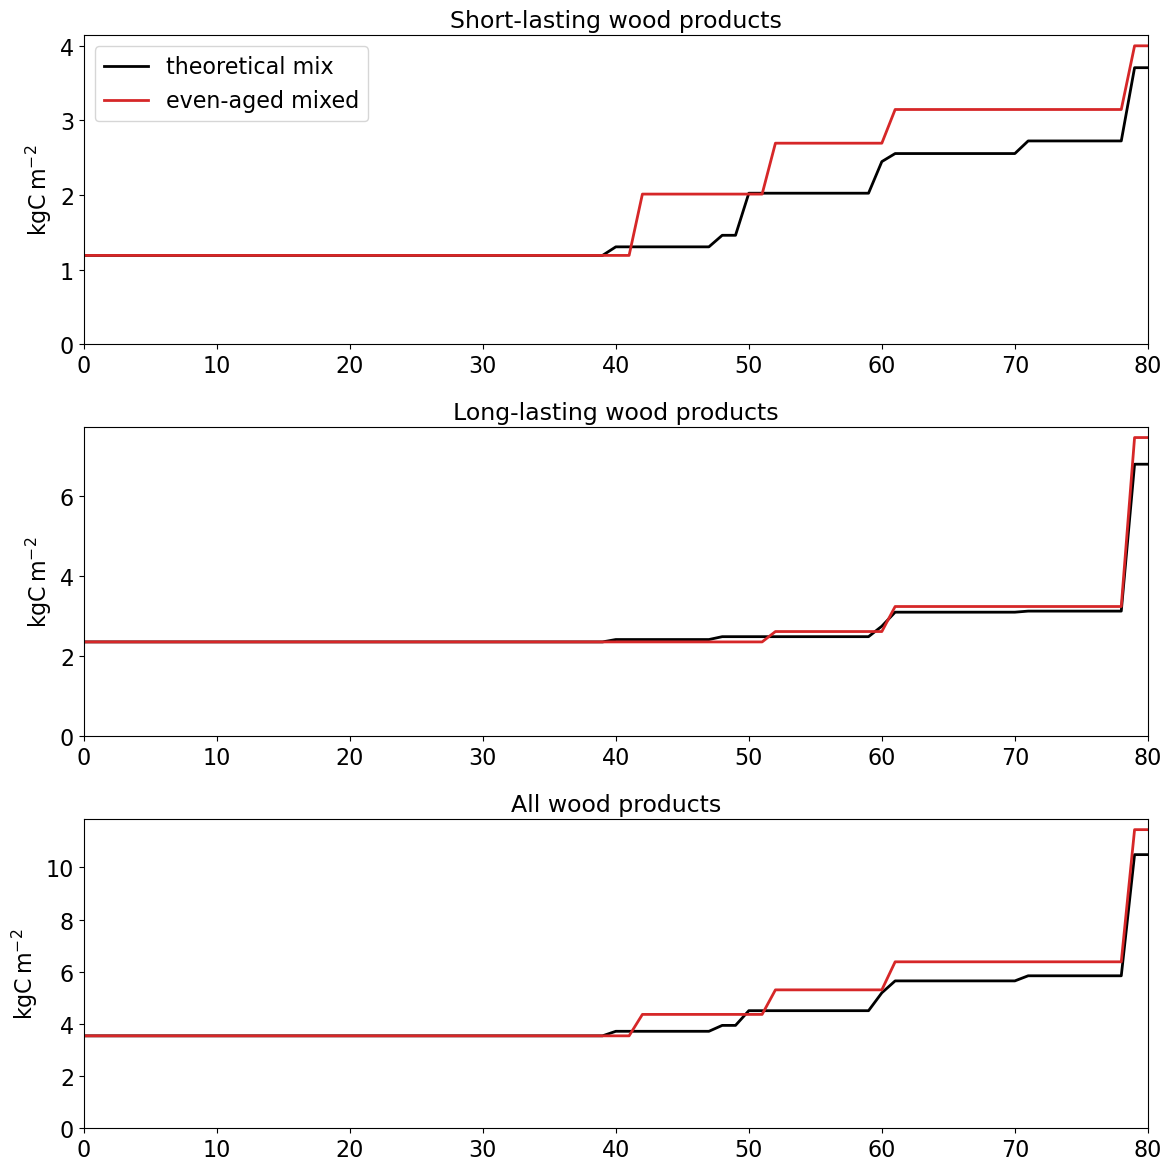

In [15]:
fig, axes = plt.subplots(figsize=(12, 4*3), nrows=3)

pools_to = ["WP_S", "WP_L"]
titles = ["Short-lasting wood products", "Long-lasting wood products"]

for ax, pool_to, title in zip(axes, pools_to, titles):
    ax.set_title(title)
    WP_cum = dict()
    for sim_name in ["even-aged_pine", "even-aged_spruce", "even-aged_mixed"]:
        ds = dss[sim_name]
        y = ds.internal_fluxes.sel(pool_to=pool_to).sum(dim=["entity_to", "entity_from", "pool_from"]).cumsum(dim="time")
        WP_cum[sim_name] = Q_(y.data, ds.stocks.attrs["units"]).to("kgC/m^2")

        
    
    x = 0.5*WP_cum["even-aged_pine"]+0.5*WP_cum["even-aged_spruce"]
    y = WP_cum["even-aged_mixed"]
    ax.plot(ds.time, x, c="black", label="theoretical mix")
    ax.plot(ds.time, y, c=colors["even-aged_mixed"], label="even-aged mixed")
    ax.set_ylabel(r"kgC$\,$m$^{-2}$")
    ax.set_xlim([0, 80])
    ax.set_ylim([0, ax.get_ylim()[1]])
    print(f"{pool_to}:, even-aged mixed: {y[-1]}, theoretical mix: {x[-1]}, overyielding:  {(y[-1]/x[-1]-1).magnitude*100}%")

ax = axes[2]
ax.set_title("All wood products")
WP_cum = dict()
for sim_name in ["even-aged_pine", "even-aged_spruce", "even-aged_mixed"]:
    ds = dss[sim_name]
    y = ds.internal_fluxes.sel(pool_to=["WP_S", "WP_L"]).sum(dim=["entity_to", "entity_from", "pool_from", "pool_to"]).cumsum(dim="time")
    WP_cum[sim_name] = Q_(y.data, ds.stocks.attrs["units"]).to("kgC/m^2")
        
x = 0.5*WP_cum["even-aged_pine"]+0.5*WP_cum["even-aged_spruce"]
y = WP_cum["even-aged_mixed"]
ax.plot(ds.time, x, c="black", label="theoretical mix")
ax.plot(ds.time, y, c=colors["even-aged_mixed"], label="even-aged mixed")
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[1]])
print(f"{pools_to}:, even-aged mixed: {y[-1]}, theoretical mix: {x[-1]}, overyielding:  {(y[-1]/x[-1]-1).magnitude*100}%")
   
axes[0].legend()
fig.tight_layout()

## Carbon sequestration and climate change mitigation

In [16]:
stocks_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    stocks = ds.total_C_stock.data # gC/m^2
    stocks_trees_and_soil = ds.total_C_stock - ds.stocks.sel(entity="wood_product").sum(dim="pool")
    data = np.array([stocks, stocks_trees_and_soil])
    stocks_datas.append(data)
    
stocks_datas = Q_(np.array(stocks_datas).transpose(), "gC/m^2").to("kgC/m^2")
stocks_datas.shape

(81, 2, 4)

In [17]:
left_behind_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    m_left_behind = ds.stocks.sel(pool=["CWD", "Litter", "SOC"]).sum(dim=["entity", "pool"])
    m_left_behind = m_left_behind.data # gC/m^2, ds.stocks.attrs["units"]).to("kgC/m^2")
    left_behind_datas.append(m_left_behind)
    
left_behind_datas = Q_(np.array(left_behind_datas).transpose(), "gC/m^2").to("kgC/m^2")
left_behind_datas.shape

(81, 4)

In [18]:
CS_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    CS = ds.CS_through_time#.isel(time=-1)
    CS = CS.data # gC/m^2 yr, CS.attrs["units"]).to("yr*kgC/m^2")
    CS_trees_and_soil = ds.CS_through_time_trees_and_soil#.isel(time=-1)
    CS_trees_and_soil = CS_trees_and_soil.data # gC/m^2 yr, CS_trees_and_soil.attrs["units"]).to("yr*kgC/m^2")
    data = np.array([CS, CS_trees_and_soil])

    CS_datas.append(data)
    
CS_datas = Q_(np.array(CS_datas).transpose(), "yr*gC/m^2").to("yr*kgC/m^2")
CS_datas.shape

(81, 2, 4)

In [19]:
CB_datas = list()

#ti = -2

for sim_name in sim_names:
    ds = dss[sim_name]
#    CB = ds.C_balance_through_time.isel(time=ti)
    x0 = ds.stocks.isel(time=0).sum(dim=["entity", "pool"])
    CB = ds.stocks.sum(dim=["entity", "pool"]) - x0
    CB = CB.data # gC/m^2
    
#    CB_trees_and_soil = ds.C_balance_through_time_trees_and_soil.isel(time=ti)
    x0_trees_and_soil = x0 - ds.stocks.isel(time=0).sel(entity="wood_product").sum(dim="pool")
    CB_trees_and_soil = (ds.stocks.sum(dim=["entity", "pool"]) - ds.stocks.sel(entity="wood_product").sum(dim="pool")) - x0_trees_and_soil
    CB_trees_and_soil = CB_trees_and_soil.data # gC/m^2
    data = np.array([CB, CB_trees_and_soil])
    
    CB_datas.append(data)
    
CB_datas = Q_(np.array(CB_datas).transpose(), "gC/m^2").to("kgC/m^2")
CB_datas.shape

(81, 2, 4)

In [20]:
cum_stocks_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    cum_stocks = ds.stocks.sum(dim=["entity", "pool"]).cumsum(dim="time")
    cum_stocks = cum_stocks.data # gC/m^2 yr, ds.stocks.attrs["units"]) * Q_("1 yr")).to("kgC/m^2 yr")
    
    trees_and_soil_entity_nrs = ds.tree_entity_nrs.data.tolist() + [ds.soil_entity_nr]
    cum_stocks_trees_and_soil = ds.stocks.isel(entity=trees_and_soil_entity_nrs).sum(dim=["entity", "pool"]).cumsum(dim="time")
    cum_stocks_trees_and_soil = cum_stocks_trees_and_soil.data # gC/m^2 yr, ds.stocks.attrs["units"]) * Q_("1 yr")).to("kgC/m^2 yr")
    
    data = np.array([cum_stocks, cum_stocks_trees_and_soil])
    cum_stocks_datas.append(data)
    
cum_stocks_datas = Q_(np.array(cum_stocks_datas).transpose(), "yr*gC/m^2").to("yr*kgC/m^2")
cum_stocks_datas.shape

(81, 2, 4)

In [21]:
yield_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    WPS_cum = ds.internal_fluxes.sel(pool_to="WP_S").sum(dim=["entity_to", "entity_from", "pool_from"]).cumsum(dim="time")
    WPS_cum = WPS_cum.data # gC/m^2, ds.stocks.attrs["units"])
    WPL_cum = ds.internal_fluxes.sel(pool_to="WP_L").sum(dim=["entity_to", "entity_from", "pool_from"]).cumsum(dim="time")
    WPL_cum = WPL_cum.data # gC/m^2, ds.stocks.attrs["units"])
#    print(sim_name, WPS_cum[-1])
    data = np.array([WPS_cum, WPL_cum])

    yield_datas.append(data)

yield_datas = Q_(np.array(yield_datas).transpose(), "gC/m^2").to("kgC/m^2")
yield_datas.shape

(81, 2, 4)

'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/bars.png'

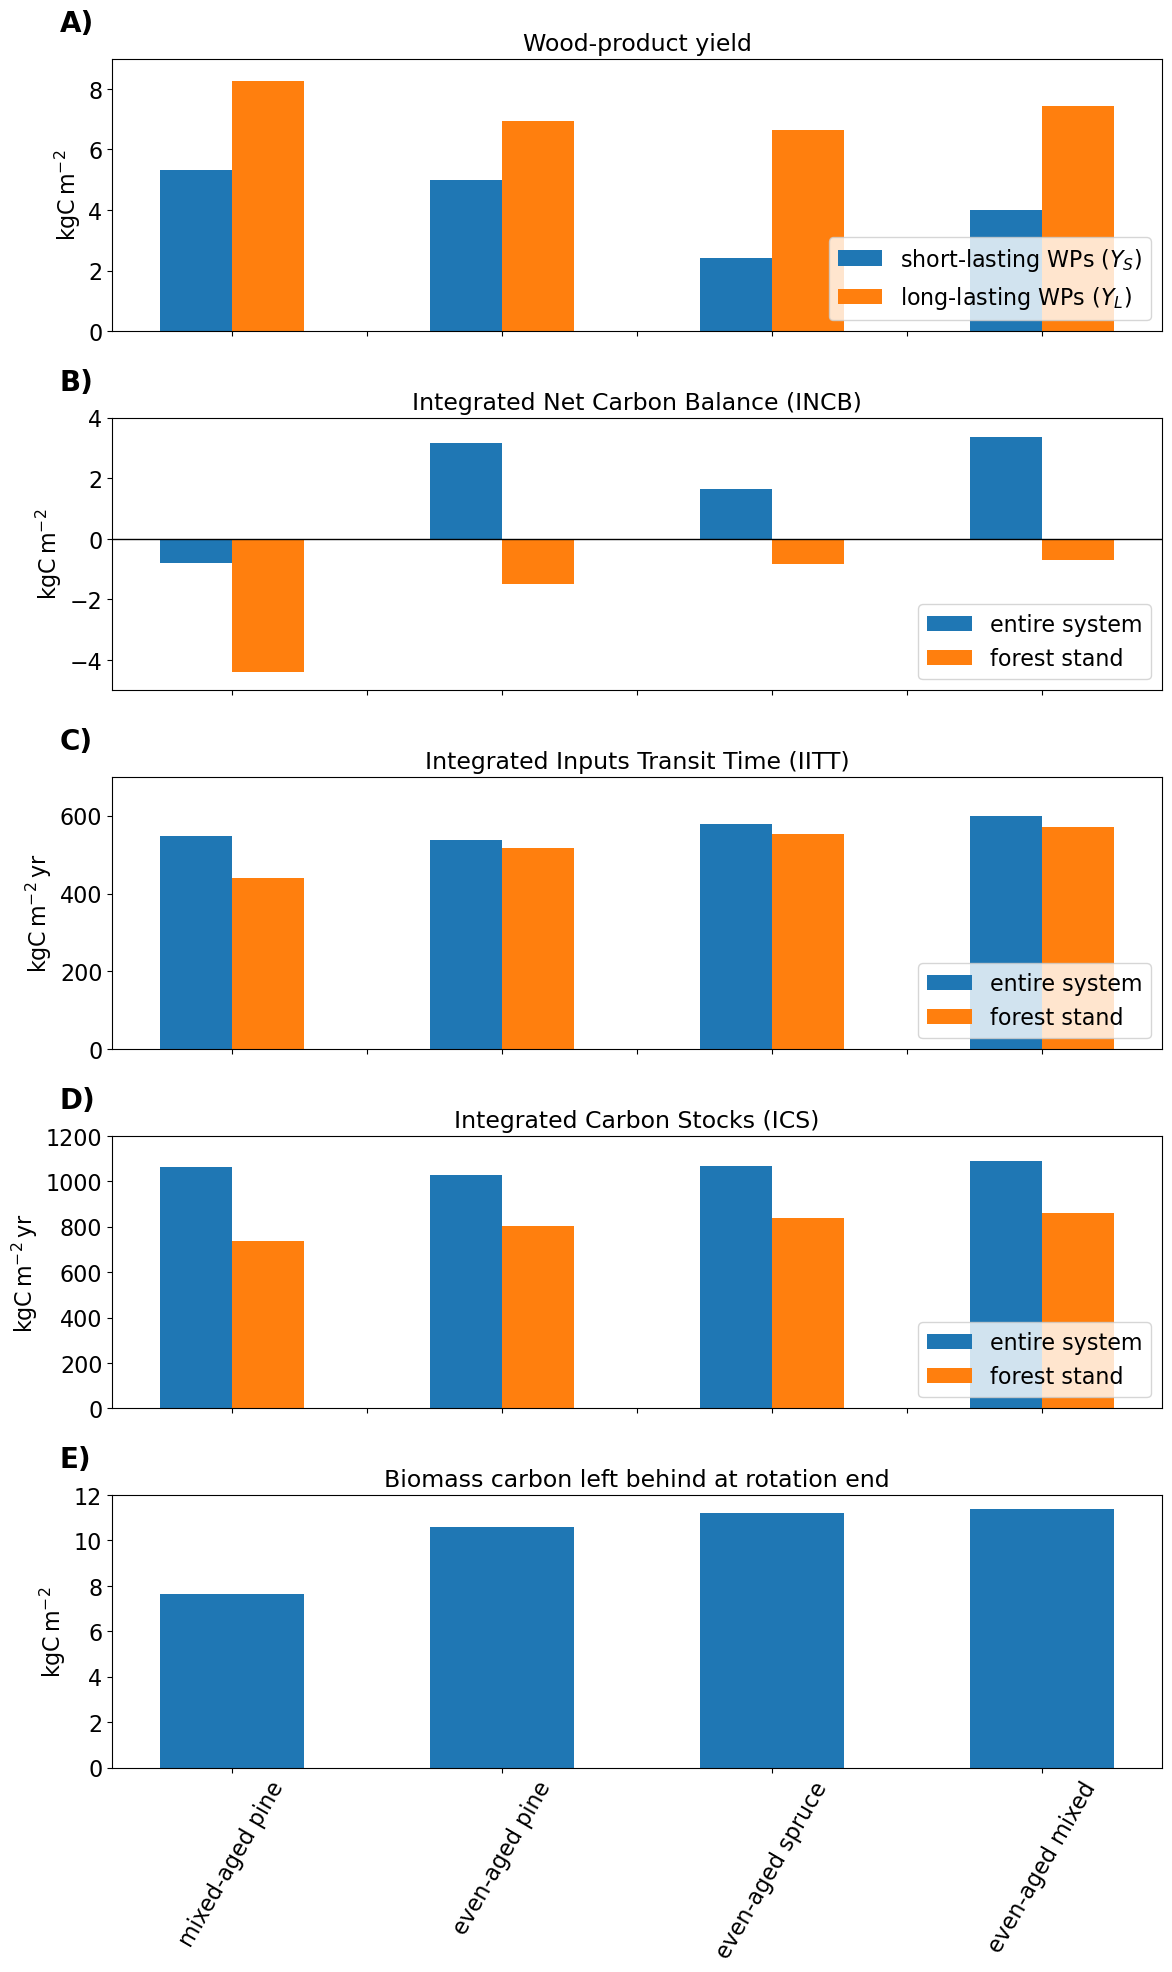

In [22]:
fig, axes = plt.subplots(figsize=(12, 4*5), nrows=5)
panel_names = iter(string.ascii_uppercase[:len(axes)])
axes = iter(axes)

make_space = 1.5

labels = [sim_name.replace("_", " ") for sim_name in sim_names]

ax = next(axes)
panel_name = next(panel_names)
x = np.arange(len(sim_names))
width = 2 / (len(sim_names)+1) / make_space
rects1 = ax.bar(x - width/2, yield_datas[-1, 0, :], width, label=r'short-lasting WPs ($Y_S$)')
rects2 = ax.bar(x + width/2, yield_datas[-1, 1, :], width, label=r'long-lasting WPs ($Y_L$)')
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.legend(loc=4)
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_title("Wood-product yield")
ax.set_xticklabels("")
ax.set_ylim([0, 9])

ax = next(axes)
panel_name = next(panel_names)
x = np.arange(len(sim_names)) 
width = 2 / (len(sim_names)+1) / make_space
rects1 = ax.bar(x - width/2, CB_datas[-1, 0, :], width, label='entire system')
rects2 = ax.bar(x + width/2, CB_datas[-1, 1, :], width, label='forest stand')
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_title("Integrated Net Carbon Balance (INCB)")
ax.axhline(0, c="black", lw=1)
ax.legend(loc=4)
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_ylim([-5, 4])


ax = next(axes)
panel_name = next(panel_names)
x = np.arange(len(sim_names)) 
width = 2 / (len(sim_names)+1) / make_space
rects1 = ax.bar(x - width/2, CS_datas[-1, 0, :], width, label='entire system')
rects2 = ax.bar(x + width/2, CS_datas[-1, 1, :], width, label='forest stand')
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_title("Integrated Inputs Transit Time (IITT)")
ax.legend(loc=4)
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_ylim([0, 700])


ax = next(axes)
panel_name = next(panel_names)
x = np.arange(len(sim_names)) 
width = 2 / (len(sim_names)+1) / make_space
rects1 = ax.bar(x - width/2, cum_stocks_datas[-1, 0, :], width, label='entire system')
rects2 = ax.bar(x + width/2, cum_stocks_datas[-1, 1, :], width, label='forest stand')
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_title("Integrated Carbon Stocks (ICS)")
ax.legend(loc=4)
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_ylim([0, 1200])


ax = next(axes)
panel_name = next(panel_names)
width = 2 / (len(sim_names)+1) * 2 / make_space
pbar = ax.bar(sim_names, left_behind_datas[-1, :], width)
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_title("Biomass carbon left behind at rotation end")
ax.set_xticklabels("")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_ylim([0, 12])

ax.set_xticks(x)
ax.set_xticklabels(labels)

for tick in ax.get_xticklabels():
    tick.set_rotation(60)
    
fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("bars.png"))
fig.savefig(filename, dpi=500)
filename

In [23]:
print("\nWPY")
for nr, sim_name in enumerate(sim_names):
    x = yield_datas[-1, :, nr]
    print(sim_name, round_arr(x.magnitude, 1), x.units)

print("\nINCB")
for nr, sim_name in enumerate(sim_names):
    x = CB_datas[-1, :, nr]
    print(sim_name, round_arr(x.magnitude, 1), x.units)

print("\nIITT")
for nr, sim_name in enumerate(sim_names):
    x = CS_datas[-1, :, nr]
    print(sim_name, round_arr(x.magnitude, 1), x.units)

print("\nICS")
for nr, sim_name in enumerate(sim_names):
    x = cum_stocks_datas[-1, :, nr]
    print(sim_name, round_arr(x.magnitude, 1), x.units)

print("\nBiomass left behind")
for nr, sim_name in enumerate(sim_names):
    x = left_behind_datas[-1, nr]
    print(sim_name, round_arr(x.magnitude, 1), x.units)    


WPY
mixed-aged_pine [5.3 8.3] kilog_carbon / meter ** 2
even-aged_pine [5.  6.9] kilog_carbon / meter ** 2
even-aged_spruce [2.4 6.6] kilog_carbon / meter ** 2
even-aged_mixed [4.  7.4] kilog_carbon / meter ** 2

INCB
mixed-aged_pine [-0.8 -4.4] kilog_carbon / meter ** 2
even-aged_pine [ 3.2 -1.5] kilog_carbon / meter ** 2
even-aged_spruce [ 1.7 -0.8] kilog_carbon / meter ** 2
even-aged_mixed [ 3.4 -0.7] kilog_carbon / meter ** 2

IITT
mixed-aged_pine [549. 440.] kilog_carbon * year / meter ** 2
even-aged_pine [537.5 516.4] kilog_carbon * year / meter ** 2
even-aged_spruce [578.5 553.2] kilog_carbon * year / meter ** 2
even-aged_mixed [599.3 572.1] kilog_carbon * year / meter ** 2

ICS
mixed-aged_pine [1061.7  737.2] kilog_carbon * year / meter ** 2
even-aged_pine [1027.5  803.8] kilog_carbon * year / meter ** 2
even-aged_spruce [1068.4  840.6] kilog_carbon * year / meter ** 2
even-aged_mixed [1089.2  859.6] kilog_carbon * year / meter ** 2

Biomass left behind
mixed-aged_pine 7.7 kil

mixed-aged_pine 1061.716849657608 kilog_carbon * year / meter ** 2 537.1107859569238 kilog_carbon * year / meter ** 2
even-aged_pine 1027.4532592938688 kilog_carbon * year / meter ** 2 431.0042630199118 kilog_carbon * year / meter ** 2
even-aged_spruce 1068.4149195992231 kilog_carbon * year / meter ** 2 464.65388499223053 kilog_carbon * year / meter ** 2
even-aged_mixed 1089.1801525976266 kilog_carbon * year / meter ** 2 457.7417275211095 kilog_carbon * year / meter ** 2


'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/yield_seq_and_ccmp.png'

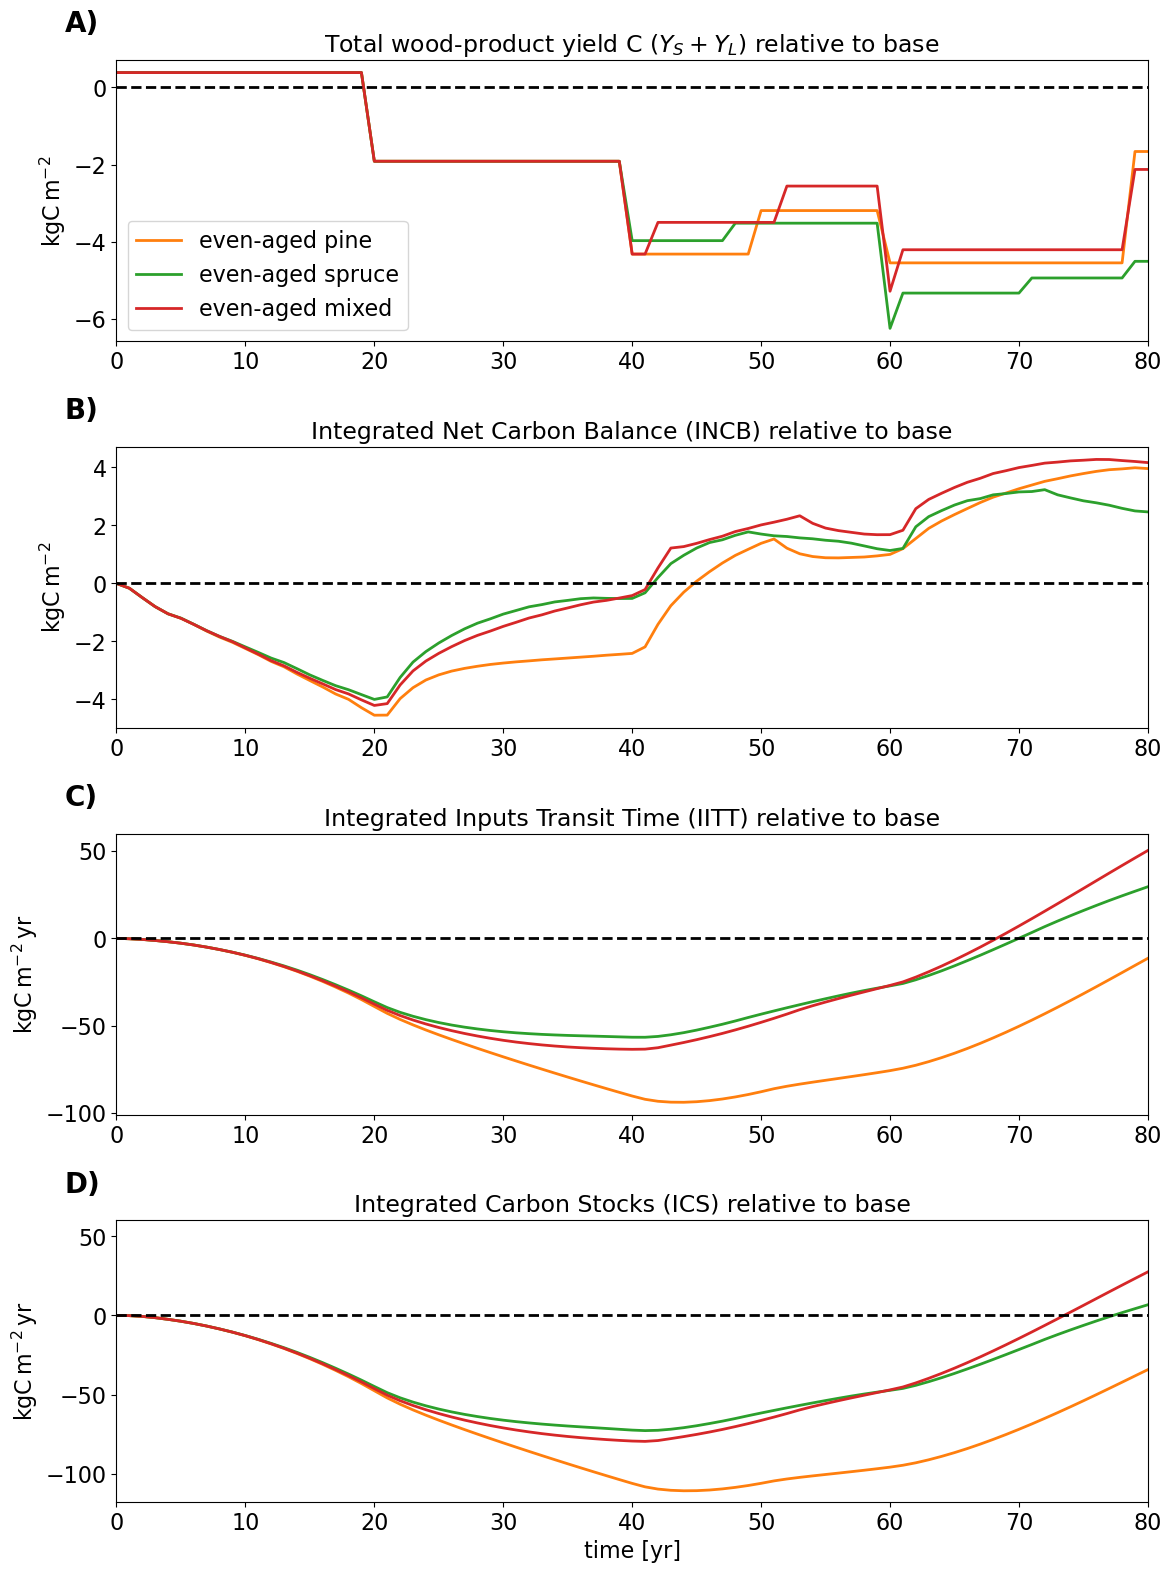

In [24]:
fig, axes = plt.subplots(figsize=(12, 4*4), nrows=4)
panel_names = iter(string.ascii_uppercase[:len(axes)])
axes = iter(axes)

base_nr = 0

ax = next(axes)
panel_name = next(panel_names)
ax.set_title(r"Total wood-product yield C ($Y_S+Y_L$) relative to base")
combined_yield_datas = yield_datas[:, 0, :] + yield_datas[:, 1, :]
for nr, sim_name in enumerate(sim_names):
    if nr == base_nr:
        continue
   
    l, = ax.plot(combined_yield_datas[:, nr] - combined_yield_datas[:, base_nr], label=sim_name.replace("_", " "), c=colors[sim_name])
    
ax.axhline(0, c="black", ls="--")
ax.legend()
ax.set_xlim([0, 80])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Integrated Net Carbon Balance (INCB) relative to base")
for nr, sim_name in enumerate(sim_names):
    if nr == base_nr:
        continue
    
    l, = ax.plot(CB_datas[:, 0, nr] - CB_datas[:, 0, base_nr], label=sim_name.replace("_", " "), c=colors[sim_name])

ax.axhline(0, c="black", ls="--")
ax.set_xlim([0, 80])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

    
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Integrated Inputs Transit Time (IITT) relative to base")
for nr, sim_name in enumerate(sim_names):
    if nr == base_nr:
        continue
    
    ax.plot(CS_datas[:, 0, nr] - CS_datas[:, 0, base_nr], label=sim_name.replace("_", " "), c=colors[sim_name])
    
ax.axhline(0, c="black", ls="--")
ax.set_ylim([ax.get_ylim()[0], 60])
ax.set_xlim([0, 80])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Integrated Carbon Stocks (ICS) relative to base")
for nr, sim_name in enumerate(sim_names):
    print(sim_name, cum_stocks_datas[-1, 0, nr], cum_stocks_datas[40, 0, nr])
    if nr == base_nr:
        continue
    
    ax.plot(cum_stocks_datas[:, 0, nr] - cum_stocks_datas[:, 0, base_nr], label=sim_name, c=colors[sim_name])

ax.axhline(0, c="black", ls="--")
ax.set_xlim([0, 80])
ax.set_ylim([ax.get_ylim()[0], 60])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.set_xlabel("time [yr]")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("yield_seq_and_ccmp.png"))
fig.savefig(filename, dpi=500)
filename

## Ordering according to different CS metrics (entire system = 0 in the middle, stand only = 1)

In [25]:
# time index of interest: 40 = half rotation, -1 = full rotation
ti = -1

### INCB

In [26]:
[sim_names[k] for k in np.argsort(-CB_datas[ti, 0, :])], -np.sort(-CB_datas[ti, 0, :]).round(1)

(['even-aged_mixed', 'even-aged_pine', 'even-aged_spruce', 'mixed-aged_pine'],
 array([ 3.4,  3.2,  1.7, -0.8]) <Unit('kilog_carbon / meter ** 2')>)

In [27]:
[sim_names[k] for k in np.argsort(-CB_datas[ti, 1, :])], -np.sort(-CB_datas[ti, 1, :]).round(1)

(['even-aged_mixed', 'even-aged_spruce', 'even-aged_pine', 'mixed-aged_pine'],
 array([-0.7, -0.8, -1.5, -4.4]) <Unit('kilog_carbon / meter ** 2')>)

### IITT

In [28]:
[sim_names[k] for k in np.argsort(-CS_datas[ti, 0, :])], -np.sort(-CS_datas[ti, 0, :]).round(1)

(['even-aged_mixed', 'even-aged_spruce', 'mixed-aged_pine', 'even-aged_pine'],
 array([599.3, 578.5, 549. , 537.5]) <Unit('kilog_carbon * year / meter ** 2')>)

In [29]:
[sim_names[k] for k in np.argsort(-CS_datas[ti, 1, :])], -np.sort(-CS_datas[ti, 1, :]).round(1)

(['even-aged_mixed', 'even-aged_spruce', 'even-aged_pine', 'mixed-aged_pine'],
 array([572.1, 553.2, 516.4, 440. ]) <Unit('kilog_carbon * year / meter ** 2')>)

# ICS

In [30]:
[sim_names[k] for k in np.argsort(-cum_stocks_datas[ti, 0, :])], -np.sort(-cum_stocks_datas[ti, 0, :]).round(1)

(['even-aged_mixed', 'even-aged_spruce', 'mixed-aged_pine', 'even-aged_pine'],
 array([1089.2, 1068.4, 1061.7, 1027.5]) <Unit('kilog_carbon * year / meter ** 2')>)

In [31]:
[sim_names[k] for k in np.argsort(-cum_stocks_datas[ti, 1, :])], -np.sort(-cum_stocks_datas[ti, 1, :]).round(1)

(['even-aged_mixed', 'even-aged_spruce', 'even-aged_pine', 'mixed-aged_pine'],
 array([859.6, 840.6, 803.8, 737.2]) <Unit('kilog_carbon * year / meter ** 2')>)

## Ordering according to different WP metrics (short-lasting = 0 in the middle, long-lasting = 1)

In [32]:
[sim_names[k] for k in np.argsort(-yield_datas[ti, 0, :])], -np.sort(-yield_datas[ti, 0, :]).round(1)

(['mixed-aged_pine', 'even-aged_pine', 'even-aged_mixed', 'even-aged_spruce'],
 array([5.3, 5. , 4. , 2.4]) <Unit('kilog_carbon / meter ** 2')>)

In [33]:
[sim_names[k] for k in np.argsort(-yield_datas[ti, 1, :])], -np.sort(-yield_datas[ti, 1, :]).round(1)

(['mixed-aged_pine', 'even-aged_mixed', 'even-aged_pine', 'even-aged_spruce'],
 array([8.3, 7.4, 6.9, 6.6]) <Unit('kilog_carbon / meter ** 2')>)

In [34]:
[sim_names[k] for k in np.argsort(-yield_datas[ti, :, :].sum(axis=0))], -np.sort(-yield_datas[ti, :, :].sum(axis=0)).round(1)

(['mixed-aged_pine', 'even-aged_pine', 'even-aged_mixed', 'even-aged_spruce'],
 array([13.6, 11.9, 11.4,  9.1]) <Unit('kilog_carbon / meter ** 2')>)

## Do we simulate a kind of self-thinning?

'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/self_thinning.png'

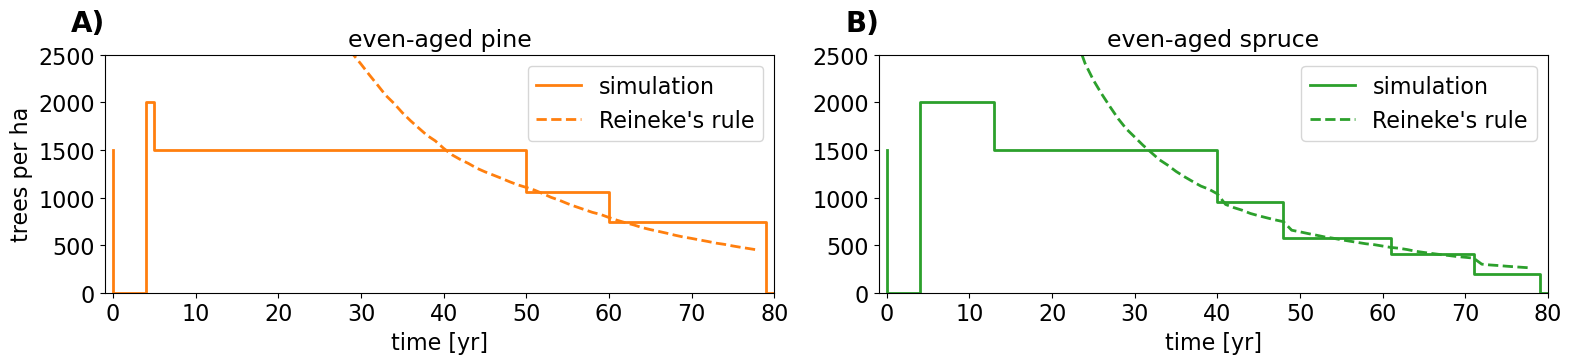

In [35]:
ha_per_acre = 0.404686
acre_per_ha = 1 / ha_per_acre

fig, axes = plt.subplots(figsize=(8*2, 4), ncols=2)
axes_list = list(axes)
panel_names = iter(string.ascii_uppercase[:len(list(axes_list))])

tis = ds.time
sim_names_tmp = ["even-aged_pine", "even-aged_spruce"]
for sim_name, ax, panel_name in zip(sim_names_tmp, axes, panel_names):
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data

    N_per_m2 = ds.N_per_m2.sel(tree=tree_names)

    # actually, Reineke wants the average to be by SBA, not by N_per_m2
#    DBH = ds.DBH.sel(tree=tree_names).weighted(N_per_m2).mean(dim="tree")
#    DBH = Q_(DBH.data, ds.DBH.attrs["units"])
    SBA = np.pi * (ds.DBH/2)**2
    D = ds.DBH.weighted(SBA.fillna(0)).mean(dim="tree")
    D = Q_(D.data, ds.DBH.attrs["units"])
           
    # times of cutting or thinning
    x = np.array([0] + [v for v in ds.time[ds.thinning_or_cutting_tree.sel(tree=tree_names).sum(dim="tree") >= 1].data] + [79])

    ax.step(tis, N_per_m2.sum(dim="tree") * 10_000, where="pre", label="simulation", c=colors[sim_name])
    
    # plot Reineke's reference curve (species independent)
#    ax.plot(tis, [(lambda x: np.exp(4.605*acre_per_ha-1.605*np.log(DBH.magnitude[x])))(ti) for ti in tis], label="Reineke's rule", c=colors[sim_name], ls="--")
    ax.plot(tis, [(lambda x: np.exp(4.605*acre_per_ha-1.605*np.log(D.magnitude[x])))(ti) for ti in tis], label="Reineke's rule", c=colors[sim_name], ls="--")
    ax.legend()
    
    ax.set_xlim([tis[0]-1, tis[-1]])
    ax.set_ylim([0, 2500])
    ax.set_title(sim_name.replace("_", " "))
    
    ax.set_xlabel("time [yr]")
    ax.text(-0.05, 1.1, panel_name + ")", transform=ax.transAxes, size=20, weight='bold')

axes[0].set_ylabel("trees per ha")

fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("self_thinning.png"))
fig.savefig(filename, dpi=500)
filename

## C in different MeanTrees

'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/tree_C.png'

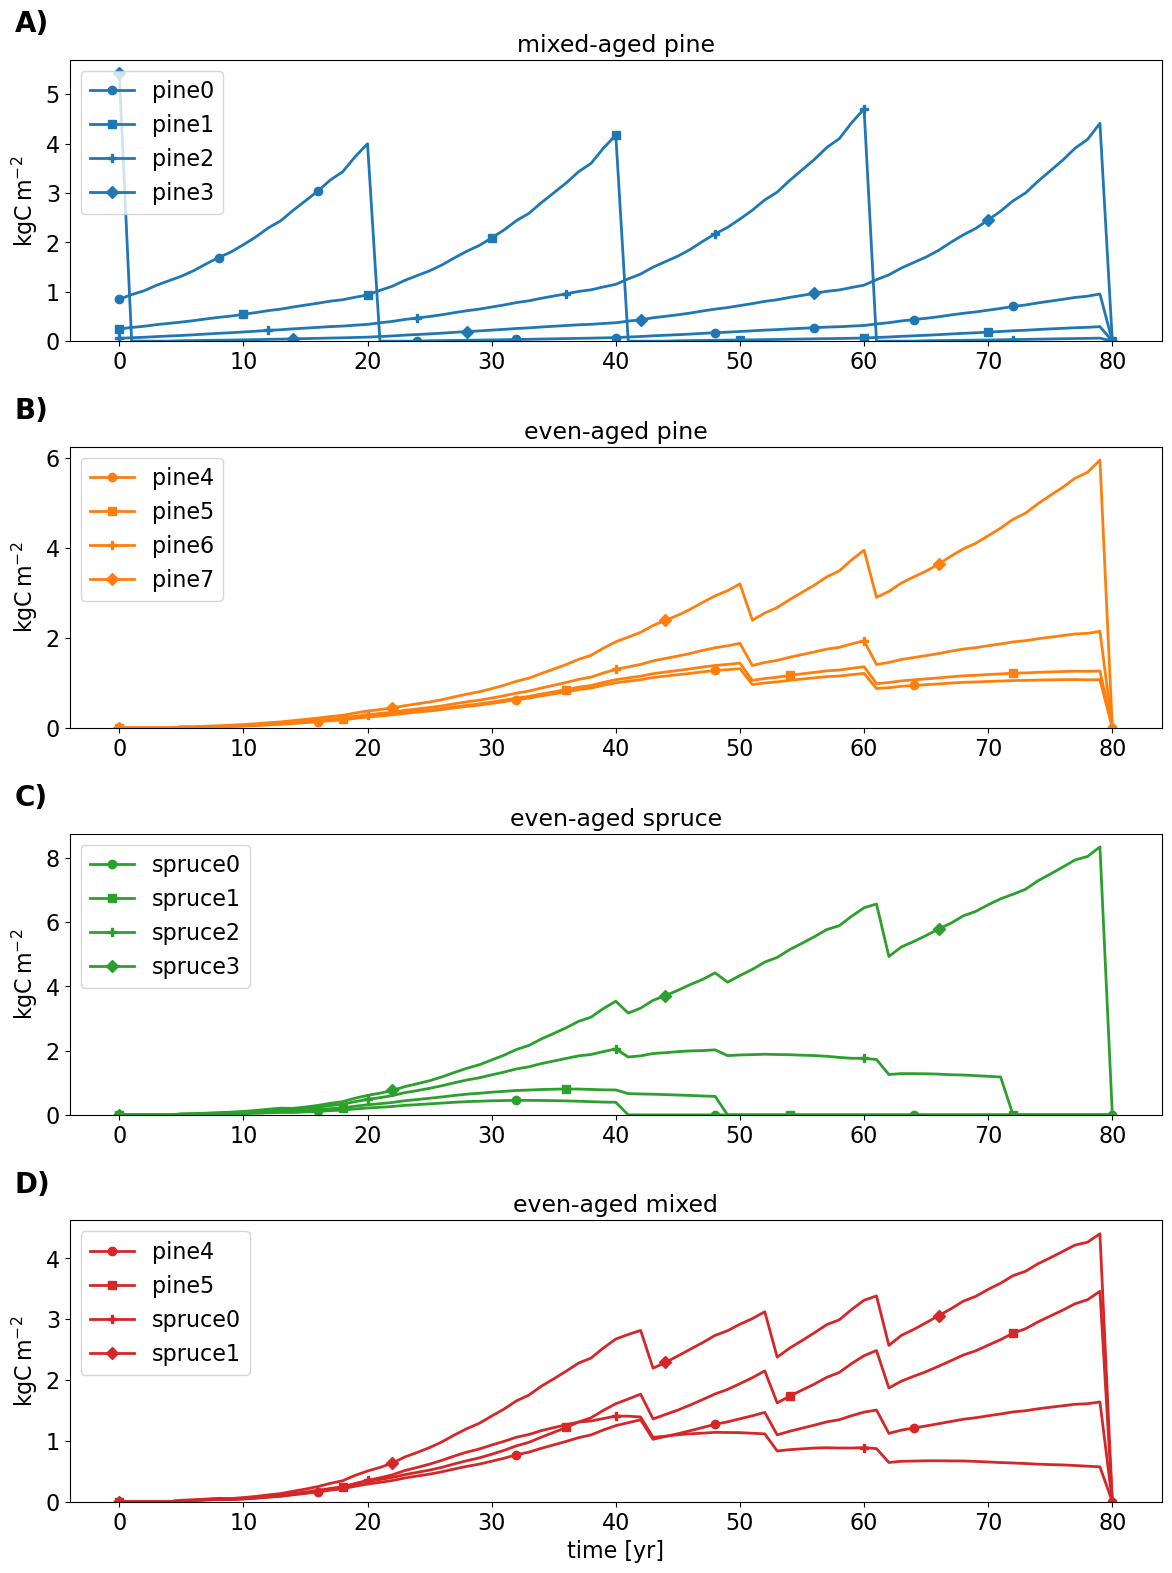

In [36]:
fig, axes = plt.subplots(figsize=(12, 4*len(sim_names)), nrows=len(sim_names))
axes_list = axes

ax0 = axes[0]
axes = iter(axes)
panel_names = iter(string.ascii_uppercase[:len(axes_list)])
markers = ["o", "s", "P", "D"]

for panel_name, sim_name, color in zip(panel_names, sim_names, colors):
    ax = next(axes)
    ax.set_title(sim_name.replace("_", " "))
    
    ds = dss[sim_name]
    color = colors[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data
    if sim_name != "mixed-aged_pine":
        tree_names = tree_names[nr_spinup_trees:]
        tree_ids = np.arange(4, 8)
    else:
        tree_ids = np.arange(0, 4)
           
    for tree_id, tree_name, marker in zip(tree_ids, tree_names, markers):
        ax.plot(
            ds.time, ds.stocks.isel(entity=tree_id).sum(dim="pool") * 1e-03,
            label=tree_name, c=color, marker=marker, markevery=8 + 2 * tree_id
        )

    ax.legend()
    ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
    ax.set_ylabel(r"kgC$\,$m$^{-2}$")
    ax.set_ylim([0, ax.get_ylim()[-1]])

axes_list[-1].set_xlabel("time [yr]")
fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("tree_C.png"))
fig.savefig(filename, dpi=500)
filename

## Benchmarking figures

## 5-yr radial growth
We check the annual radial growth at breast height over 5 years, because Repola (2008: birch, 2009: pine and spruce) provides values for it. Naturally, we use `r_BH = tree_in_stand.dbh / 2` for that.

- Repola (2009):
    - pine: mean=0.54 cm, std=0.33, range=0.04-2.03
    - spruce: mean=0.76 cm, std=0.41, range=0.07-2.48
    
In the plots below, the dashed line represents the Repola mean, the semi-transparent area is the Repola standard deviation around the mean and the even more transparent area is the range of values found in Repola.

In [37]:
def compute_r_BH_growth_5_yrs_for_single_ti(DBH_tree, ti):
    if ti < 4:
        return np.nan
    
    dbhs = DBH_tree[(ti-4):(ti+1)]
    Delta_r_5_yrs = (dbhs[-1]-dbhs[0]) / 2
    if Delta_r_5_yrs < 0:
        return np.nan
        
    return float(Delta_r_5_yrs.data)
        
def compute_r_BH_growth_5_yrs(ds, tree_names):
    DBH = ds.DBH.sel(tree=tree_names)
    N_per_m2 = ds.N_per_m2.sel(tree=tree_names)

    num: float = 0
    denom: float = 0
    for tree_name in tree_names:
        DBH_tree = DBH.sel(tree=tree_name)
        Delta_r_5_yrs_tree = np.array([compute_r_BH_growth_5_yrs_for_single_ti(DBH_tree, ti) for ti in range(len(DBH_tree))])
        Delta_r_5_yrs_tree[np.isnan(Delta_r_5_yrs_tree)] = 0
        
        N_per_m2_tree = N_per_m2.sel(tree=tree_name).data
        N_per_m2_tree[np.isnan(N_per_m2_tree)] = 0
        num += Delta_r_5_yrs_tree * N_per_m2_tree
        denom += N_per_m2_tree
    
    res = num / denom
    res[res == 0] = np.nan
    return res

/tmp/ipykernel_1864/2702277099.py:28: RuntimeWarning: invalid value encountered in divide
  res = num / denom
/tmp/ipykernel_1864/2702277099.py:28: RuntimeWarning: invalid value encountered in divide
  res = num / denom


'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/benchmarking_radial_growth.png'

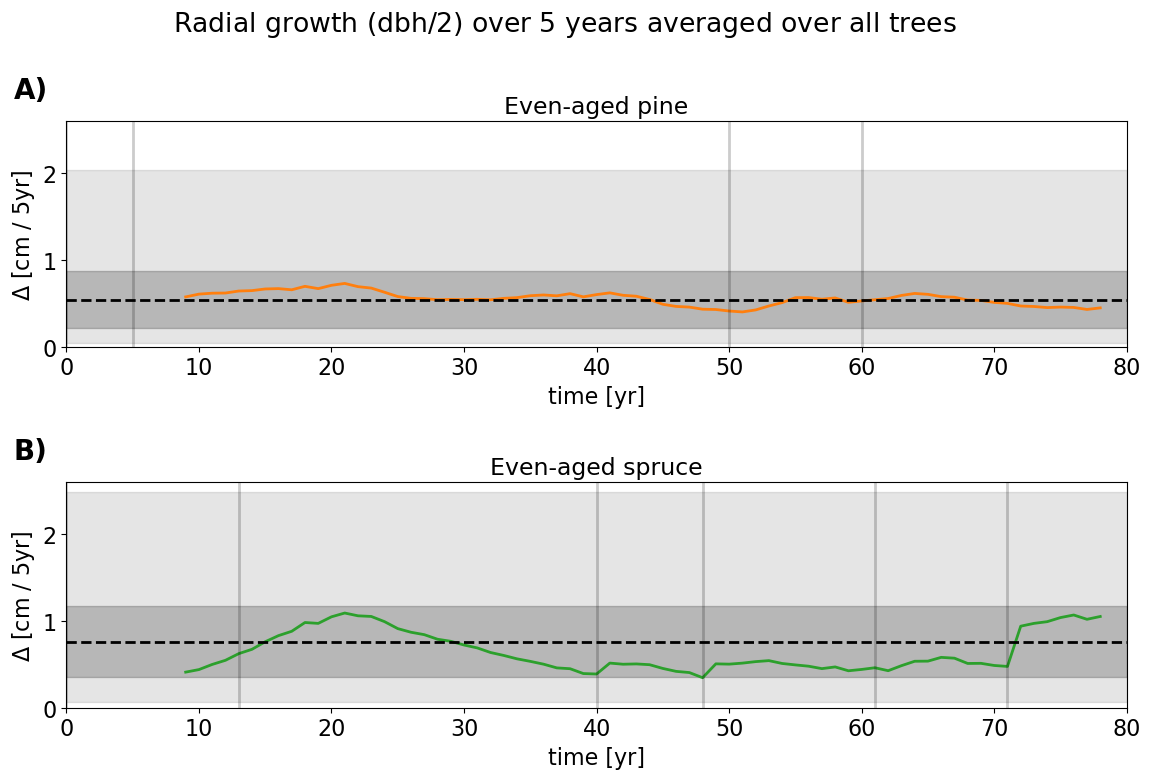

In [38]:
sim_names_tmp = ["even-aged_pine", "even-aged_spruce"]

fig, axes = plt.subplots(figsize=(12, 4*len(sim_names_tmp)), nrows=len(sim_names_tmp))

species_data = {
    "pine": {"mean": 0.54, "std": 0.33, "range": (0.04, 2.03)},
    "spruce": {"mean": 0.76, "std": 0.41, "range": (0.07, 2.48)},
    "birch": {"mean": 0.75, "std": 0.58, "range": (0.05, 3.47)},
}

fig.suptitle("Radial growth (dbh$/2$) over 5 years averaged over all trees")
titles = [s.replace("_", " ").capitalize() for s in sim_names_tmp]
for sim_name, ax, title, panel_name in zip(sim_names_tmp, axes, titles, string.ascii_uppercase[:len(axes)]):
    ds = dss[sim_name]
    ax.set_title(title)
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data[nr_spinup_trees:]
    species = str(ds.species.sel(tree=tree_names[0]).data)
    
    r_BH_growth_5_yrs = compute_r_BH_growth_5_yrs(ds, tree_names)
    l, = ax.plot(ds.time, r_BH_growth_5_yrs, c=colors[sim_name])
   
    mean = species_data[species]["mean"]
    std = species_data[species]["std"]
    range_ = species_data[species]["range"]
    n = len(ds.time)
    ax.fill_between(ds.time, [mean-std]*n, [mean+std]*n, alpha=0.2, color="black")
    ax.fill_between(ds.time, [range_[0]]*n, [range_[1]]*n, alpha=0.1, color="black")
    ax.axhline(y=mean, c="black", ls="--")
    
    ax.set_xlim([ds.time[0], ds.time[-1]])
    ax.set_ylim([0, 2.6])
    ax.set_xlabel("time [yr]")
    ax.set_ylabel(r"$\Delta$ [cm / 5yr]")
    ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

    # vertical thinning lines
    for x in ds.time[ds.thinning_or_cutting_tree.sum(dim="tree") >= 1][:-1]:
        ax.axvline(x.data, alpha=0.2, color="black")
    
fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("benchmarking_radial_growth.png"))
fig.savefig(filename, dpi=500)
filename

### Check allometric accuracy for MeanTrees

'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/benchmarking_allometries.png'

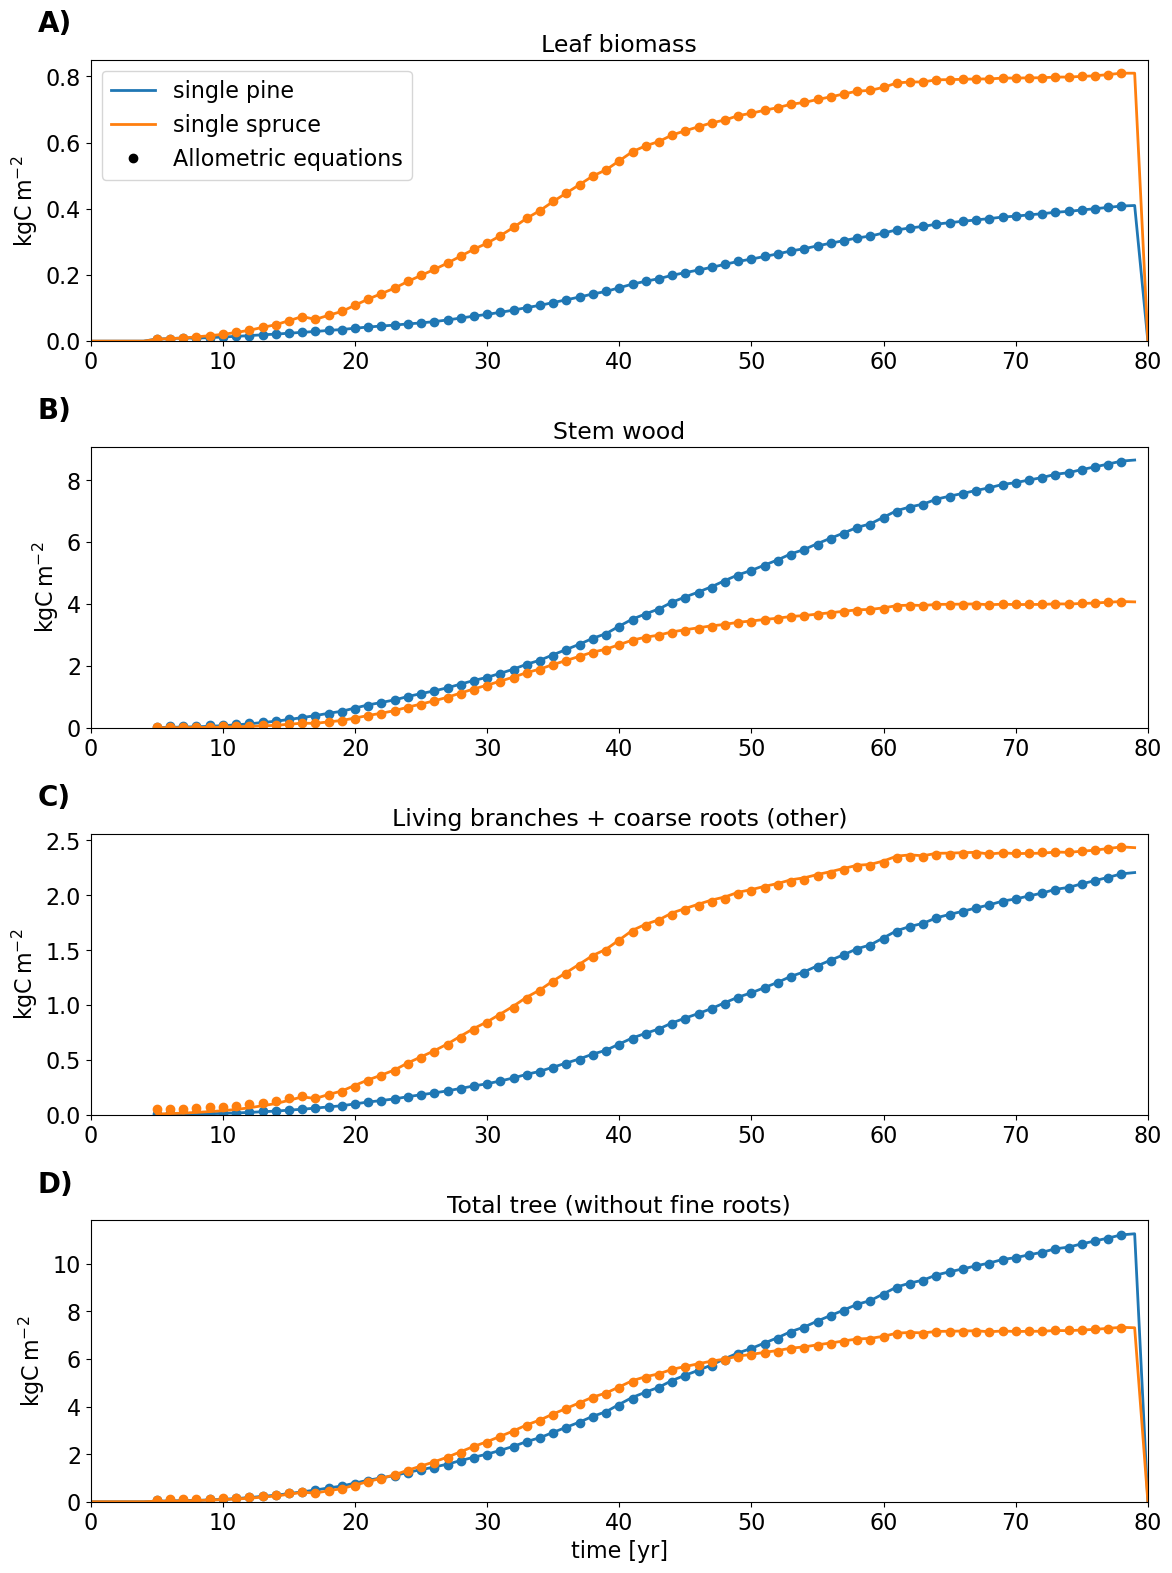

In [39]:
sim_names_tmp = ["single_pine", "single_spruce"]

fig, axes = plt.subplots(figsize=(12, 4*4), nrows=4)
panel_names = iter(string.ascii_uppercase[:len(axes)])
axes = iter(axes)

# D = B_L + C_L
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Leaf biomass")
for sim_name in sim_names_tmp:
    ds = dss_benchmarking[sim_name]
    tree_name = ds.entity[0].data
    tree_species = str(ds.species.sel(tree=tree_name).data)
    
    l = ax.plot(
        ds.time,
        1e-03 * (ds.stocks.sel(entity=tree_name, pool="B_L")+ds.stocks.sel(entity=tree_name, pool="C_L")),
        label=f"single {tree_species}"
    )

    dbhs = ds.DBH.sel(tree=tree_name).data
    Hs = ds.height.sel(tree=tree_name).data
        
    Ns_per_m2 = Q_(ds.N_per_m2.sel(tree=tree_name).data, ds.N_per_m2.attrs["units"])
    
    components = ("leaves",)
    mleaf = [allometries(dbh, H, tree_species, components, species_params) for dbh, H in zip(dbhs, Hs)]
    mleaf = Q_(np.array(mleaf), "kg_dw").to("kgC") * Ns_per_m2
    ax.plot(mleaf, color=l[0].get_c(), ls="", marker="o", label="Allometric equations")
    
h, l = ax.get_legend_handles_labels()
h_adapted = [h[k] for k in [0, 2]]
l_adapted = [l[k] for k in [0, 2]]
nl = Line2D([0], [0], label="Allometric equations", ls="", marker="o", color="black")
h_adapted.extend([nl])
ax.legend(handles=h_adapted)

ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


# A + B + F = B_TS + B_TH + C_S * B_TS / (B_OS + B_TS)
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Stem wood")
for sim_name in sim_names_tmp:
    ds = dss_benchmarking[sim_name]
    tree_name = ds.entity[0].data
    tree_species = str(ds.species.sel(tree=tree_name).data)
    tree_data = ds.stocks.sel(entity=tree_name)
    
    dbhs = ds.DBH.sel(tree=tree_name).data
    Hs = ds.height.sel(tree=tree_name).data
    
    Ns_per_m2 = Q_(ds.N_per_m2.sel(tree=tree_name).data, ds.N_per_m2.attrs["units"])
    
    B_OS = tree_data.sel(pool="B_OS")
    B_TS = tree_data.sel(pool="B_TS")
    rhs = 1e-03 * (
        B_TS + tree_data.sel(pool="B_TH") +
        tree_data.sel(pool="C_S") * B_TS/(B_OS+B_TS)
    )
    l = ax.plot(rhs, label=tree_name)
    
    components = ("stemwood", "stembark", "stump")
    mstem = [allometries(dbh, H, tree_species, components, species_params) for dbh, H in zip(dbhs, Hs)]
    mstem = Q_(np.array(mstem), "kg_dw").to("kgC") * Ns_per_m2
    ax.plot(mstem, color=l[0].get_c(), ls="", marker="o", label="Allometric equations")
    
#    print("Maximum stem C deviation,", tree_species)
#    print(np.abs(rhs.data-mstem.magnitude)/rhs.data*100)
#    print(np.nanmax((np.abs(rhs.data-mstem.magnitude)/rhs.data*100)[20:]))

ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


# C – D + G + H = B_R + C_R + B_OS + B_OH + C_S * B_OS / (B_OS + B_TS)
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Living branches + coarse roots (other)")
for sim_name in sim_names_tmp:
    ds = dss_benchmarking[sim_name]
    tree_name = ds.entity[0].data
    tree_species = str(ds.species.sel(tree=tree_name).data)
    tree_data = ds.stocks.sel(entity=tree_name)
    
    dbhs = ds.DBH.sel(tree=tree_name).data
    Hs = ds.height.sel(tree=tree_name).data
    Ns_per_m2 = Q_(ds.N_per_m2.sel(tree=tree_name).data, ds.N_per_m2.attrs["units"])

    B_OS = tree_data.sel(pool="B_OS")
    B_TS = tree_data.sel(pool="B_TS")
    rhs = 1e-03 * (
        B_OS + tree_data.sel(pool="B_OH") +
        tree_data.sel(pool="C_S") * B_OS/(B_OS+B_TS)
    )
    l = ax.plot(rhs, label=tree_name)
    
    components = ("livingbranches", "roots")
    mother = [allometries(dbh, H, tree_species, components, species_params) for dbh, H in zip(dbhs, Hs)]
    lhs = Q_(np.array(mother), "kg_dw").to("kgC") * Ns_per_m2
       
    ax.plot(lhs, color=l[0].get_c(), ls="", marker="o", label="Allometric equations")
    
ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

  
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Total tree (without fine roots)")
for sim_name in sim_names_tmp:
    ds = dss_benchmarking[sim_name]
    tree_name = ds.entity[0].data
    tree_species = str(ds.species.sel(tree=tree_name).data)

    l = ax.plot(1e-03 * (ds.stocks.sel(entity=tree_name).sum(dim="pool") - ds.stocks.sel(entity=tree_name, pool=["E", "B_R", "C_R"]).sum(dim="pool")), label=tree_name) 
    
    dbhs = ds.DBH.sel(tree=tree_name).data
    Hs = ds.height.sel(tree=tree_name).data
    Ns_per_m2 = Q_(ds.N_per_m2.sel(tree=tree_name).data, ds.N_per_m2.attrs["units"])

    components = ("leaves", "stemwood", "stembark", "livingbranches", "stump", "roots")
    mtotal = [allometries(dbh, H, tree_species, components, species_params) for dbh, H in zip(dbhs, Hs)]
    mtotal = Q_(np.array(mtotal), "kg_dw").to("kgC") * Ns_per_m2
    ax.plot(mtotal, color=l[0].get_c(), ls="", marker="o", label="Allometric equations")

ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_xlabel("time [yr]")
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("benchmarking_allometries.png"))
fig.savefig(filename, dpi=500)
filename

# Compute amont of carbon transferred by cuttings in mixed-aged pine scenario (kgC/m$^2$)

In [40]:
ds = dss["mixed-aged_pine"]

# when which tree was cut
data =[
    (2000, ["pine3"]), (2020, ["pine0"]), (2040, ["pine1"]), (2060, ["pine2"]),
    (2079, ["pine0", "pine1", "pine2", "pine3"])
]

for (year, tree_names) in data:
    print(year)
    print("Soil:", round(ds.internal_fluxes.sel(entity_from=tree_names, entity_to="soil", time=year-2000).sum(dim=["entity_from", "pool_from", "pool_to"]).data / 1000, 1))
    print("WP:", round(ds.internal_fluxes.sel(entity_from=tree_names, entity_to="wood_product", time=year-2000).sum(dim=["entity_from", "pool_from", "pool_to"]).data / 1000, 1))
    print("    WP_S:", round(ds.internal_fluxes.sel(entity_from=tree_names, entity_to="wood_product", pool_to="WP_S", time=year-2000).sum(dim=["entity_from", "pool_from"]).data / 1000, 1))
    print("    WP_L:", round(ds.internal_fluxes.sel(entity_from=tree_names, entity_to="wood_product", pool_to="WP_L", time=year-2000).sum(dim=["entity_from", "pool_from"]).data / 1000, 1))

2000
Soil: 2.3
WP: 3.2
    WP_S: 0.8
    WP_L: 2.4
2020
Soil: 1.7
WP: 2.3
    WP_S: 1.1
    WP_L: 1.2
2040
Soil: 1.8
WP: 2.4
    WP_S: 1.0
    WP_L: 1.4
2060
Soil: 2.0
WP: 2.7
    WP_S: 0.9
    WP_L: 1.8
2079
Soil: 2.7
WP: 3.0
    WP_S: 1.4
    WP_L: 1.5


## Overyielding (WP_S + WP_L and INCB + IITT + ICS)

In [41]:
sim_name = 'mixed-aged_pine'
ds = dss[sim_name]

In [42]:
dmr = dmrs[sim_name]
dmr.initialize_state_transition_operator_matrix_cache(10_000)
dmr.nr_pools

45

In [43]:
nr_tree_pools, nr_pines, nr_spruces = 10, 2, 2
base_pool_nr = 0# nr_spinup_trees * nr_tree_pools
pine_pools = np.arange(base_pool_nr, base_pool_nr + nr_pines * nr_tree_pools)
print(pine_pools)
base_pool_nr = base_pool_nr + nr_pines * nr_tree_pools
spruce_pools = np.arange(base_pool_nr, base_pool_nr + nr_spruces * nr_tree_pools)
print(spruce_pools)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [44]:
mask_pine = np.ones(dmr.start_values.shape, dtype=bool)
mask_pine[pine_pools] = False

#start_values_pine = dmr.start_values.copy()
#start_values_pine[mask_pine] = 0

net_Us_pine = dmr.net_Us.copy()
net_Us_pine[:, mask_pine] = 0

dmr_pine = DMR.from_Bs_and_net_Us(dmr.start_values, dmr.times, dmr.Bs, net_Us_pine)
dmr_pine.initialize_state_transition_operator_matrix_cache(10_000)

In [45]:
mask_spruce = np.ones(dmr.start_values.shape, dtype=bool)
mask_spruce[spruce_pools] = False

#start_values_spruce = dmr.start_values.copy()
#start_values_spruce[mask_spruce] = 0

net_Us_spruce = dmr.net_Us.copy()
net_Us_spruce[:, mask_spruce] = 0

dmr_spruce = DMR.from_Bs_and_net_Us(dmr.start_values, dmr.times, dmr.Bs, net_Us_spruce)
dmr_spruce.initialize_state_transition_operator_matrix_cache(10_000)

In [46]:
WP_cum = dict()
for pool_to in ["WP_S", "WP_L"]:
    WP_cum[pool_to] = dict()
    for sim_name in sim_names:
        WP_cum[pool_to][sim_name] = dict()
        ds = dss[sim_name]
        for species in ["pine", "spruce"]:
            species_entity_nrs = ds.tree_entity_nrs[ds.species.data==species]
            if sim_name != "mixed-aged_pine":
                species_entity_nrs = species_entity_nrs[species_entity_nrs >= nr_spinup_trees]
                
            if len(species_entity_nrs) > 0:
                y = ds.internal_fluxes.isel(entity_from=species_entity_nrs).sel(entity_to="wood_product", pool_to=pool_to).sum(dim=["tree_entity_nrs", "pool_from"]).cumsum(dim="time")
                y = Q_(y.data, ds.stocks.attrs["units"]).to("kgC/m^2")
                
                y = y - y[0]
                WP_cum[pool_to][sim_name][species] = y
        
        d = WP_cum[pool_to][sim_name]
        d["total"] = Q_(np.sum([data.data for data in d.values()], axis=0), "kgC/m^2")
    
    d = WP_cum[pool_to]
    d["theoretical mix"] = 0.5 * d["even-aged_pine"]["total"] + 0.5 * d["even-aged_spruce"]["total"]

In [47]:
INCB = dict()
for sim_nr, sim_name in enumerate(sim_names):
    INCB[sim_name] = CB_datas[:, 0, sim_nr]
INCB["theoretical mix"] = 0.5 * INCB["even-aged_pine"] + 0.5 * INCB["even-aged_spruce"]

In [48]:
IITT = dict()
for sim_nr, sim_name in enumerate(sim_names):
    IITT[sim_name] = CS_datas[:, 0, sim_nr]

IITT["pine in the mix"] = Q_(dmr_pine.CS_through_time(0, verbose=True) / 1000, "kgC / m^2 * yr")
IITT["spruce in the mix"] = Q_(dmr_spruce.CS_through_time(0, verbose=True) / 1000, "kgC / m^2 * yr")
IITT["theoretical mix"] = 0.5 * IITT["even-aged_pine"] + 0.5 * IITT["even-aged_spruce"]

100%|███████████████████████████████████████| 81/81 [00:03<00:00, 23.47it/s]


In [49]:
ICS = dict()
#ICS["pine"] = Q_(np.cumsum(dmr_pine.solve().sum(axis=1)), "gC / m^2 * yr")
#ICS["spruce"] = Q_(np.cumsum(dmr_spruce.solve().sum(axis=1)), "gC / m^2 * yr")
for sim_nr, sim_name in enumerate(sim_names):
    ICS[sim_name] = cum_stocks_datas[:, 0, sim_nr]

ICS["theoretical mix"] = 0.5 * ICS["even-aged_pine"] + 0.5 * ICS["even-aged_spruce"]

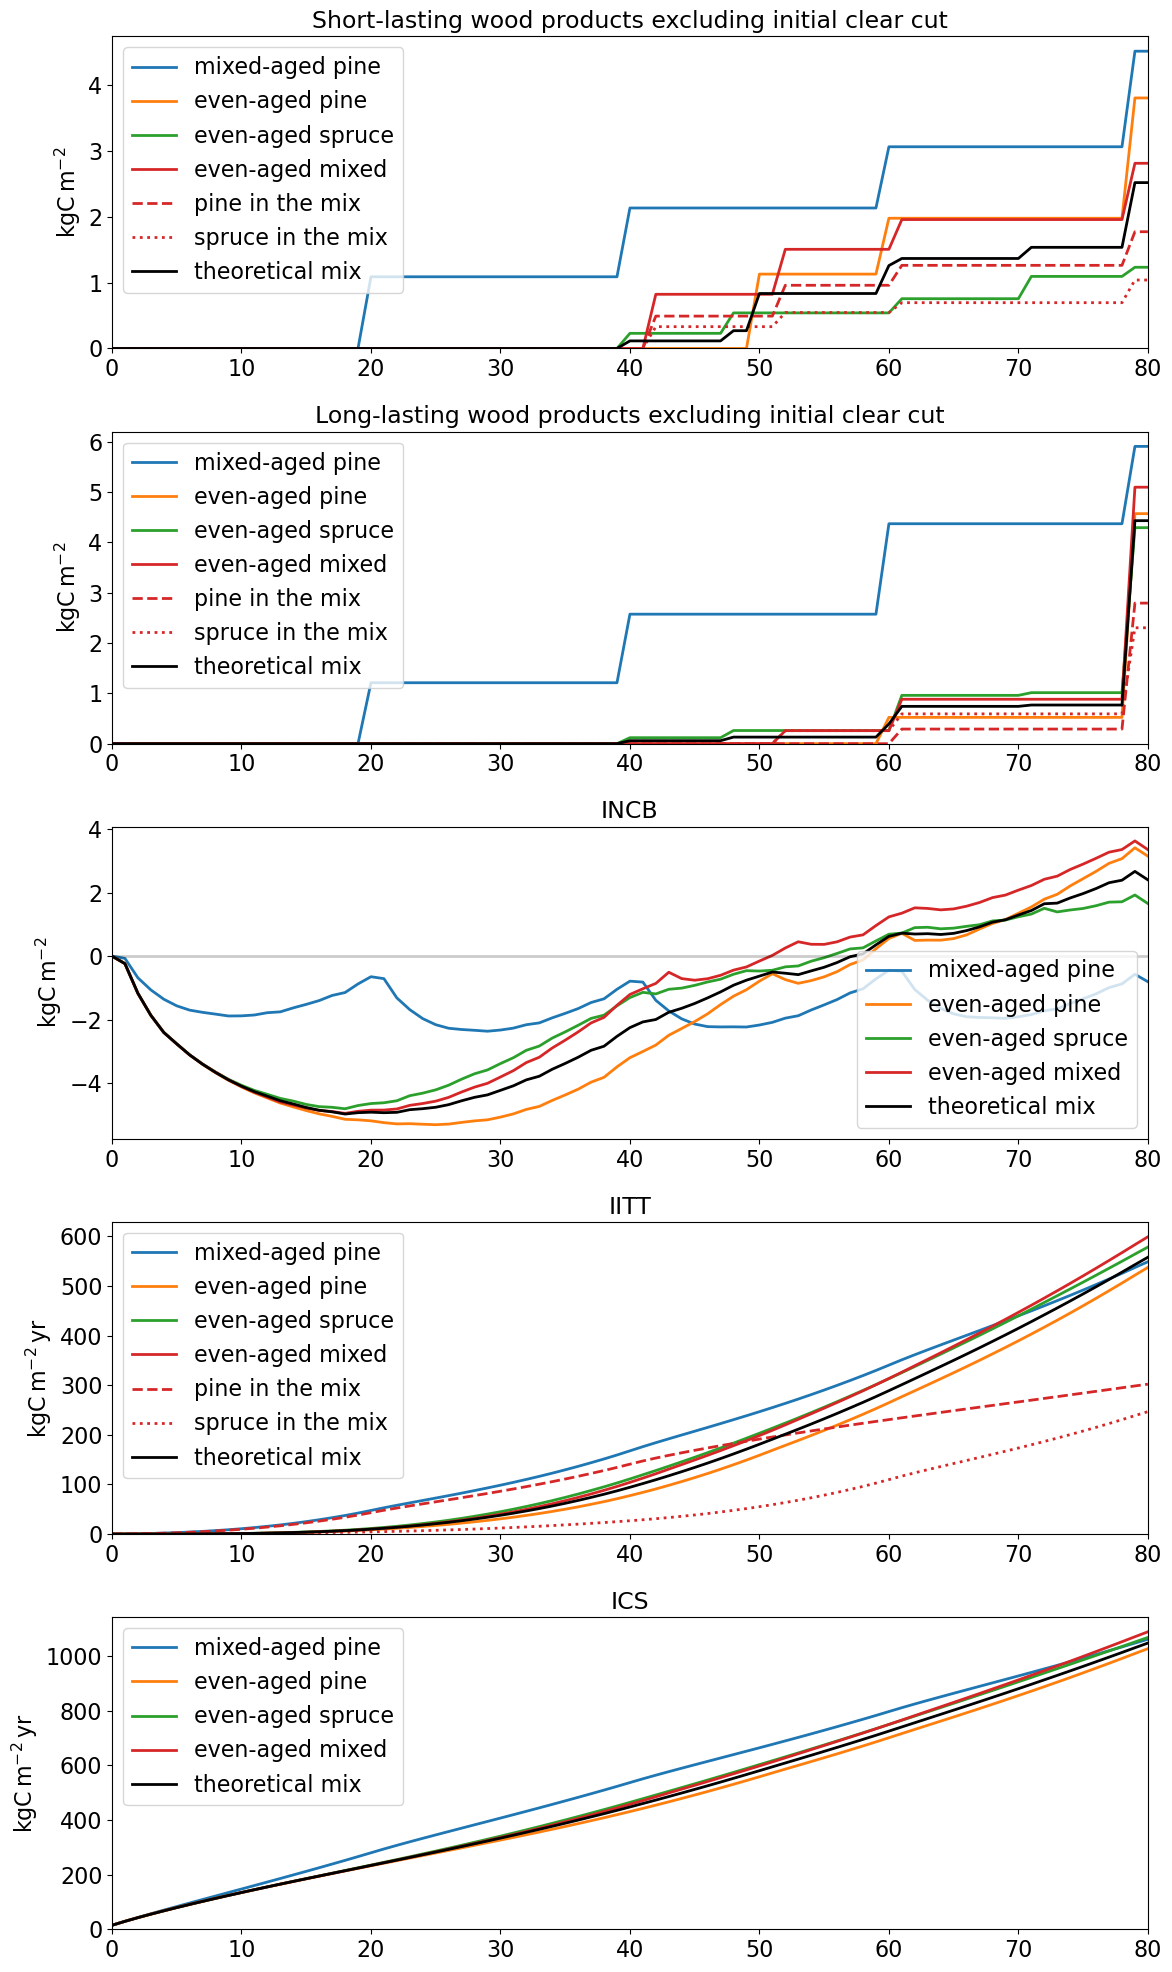

In [50]:
fig, axes = plt.subplots(figsize=(12, 4*5), nrows=5)

ax = axes[0]
ax.set_title("Short-lasting wood products excluding initial clear cut")
d = WP_cum["WP_S"]
for sim_name in sim_names:
    color = colors[sim_name]
    ax.plot(ds.time, d[sim_name]["total"], label=sim_name.replace("_", " "), color=color)

sim_name = "even-aged_mixed"
color = colors[sim_name]
ax.plot(ds.time, d[sim_name]["pine"], label="pine in the mix", ls="--", color=colors["even-aged_mixed"])
ax.plot(ds.time, d[sim_name]["spruce"], label="spruce in the mix", ls=":", color=colors["even-aged_mixed"])
ax.plot(ds.time, d["theoretical mix"], label="theoretical mix", color="black")

ax.legend()
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_ylim([0, ax.get_ylim()[-1]])


ax = axes[1]
ax.set_title("Long-lasting wood products excluding initial clear cut")
d = WP_cum["WP_L"]
for sim_name in sim_names:
    color = colors[sim_name]
    ax.plot(ds.time, d[sim_name]["total"], label=sim_name.replace("_", " "), color=color)

sim_name = "even-aged_mixed"
color = colors[sim_name]
ax.plot(ds.time, d[sim_name]["pine"], label="pine in the mix", ls="--", color=colors["even-aged_mixed"])
ax.plot(ds.time, d[sim_name]["spruce"], label="spruce in the mix", ls=":", color=colors["even-aged_mixed"])
ax.plot(ds.time, d["theoretical mix"], label="theoretical mix", color="black")
ax.legend()

ax.legend()
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.set_ylim([0, ax.get_ylim()[-1]])


ax = axes[2]
ax.set_title("INCB")
for sim_name in sim_names:
    ax.plot(ds.time, INCB[sim_name], label=sim_name.replace("_", " "))

ax.plot(ds.time, INCB["theoretical mix"], color="black", label="theoretical mix")
ax.axhline(0, c="black", alpha=0.2, lw=2)
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.legend()

ax = axes[3]
ax.set_title("IITT")
for sim_name in sim_names:
    ax.plot(ds.time, IITT[sim_name], label=sim_name.replace("_", " "))
ax.plot(ds.time, IITT["pine in the mix"], ls="--", color=colors["even-aged_mixed"], label="pine in the mix")
ax.plot(ds.time, IITT["spruce in the mix"], ls=":", color=colors["even-aged_mixed"], label="spruce in the mix")
ax.plot(ds.time, IITT["theoretical mix"], color="black", label="theoretical mix")
ax.legend()

ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")

ax = axes[4]
ax.set_title("ICS")
for sim_name in sim_names:
    ax.plot(ds.time, ICS[sim_name], label=sim_name.replace("_", " "))
ax.plot(ds.time, ICS["theoretical mix"], color="black", label="theoretical mix")
ax.legend()
ax.set_ylim([0, ax.get_ylim()[-1]])

for ax in axes:
    ax.set_xlim([0, 80])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")

fig.tight_layout()

In [51]:
base = IITT["pine in the mix"][-1] + IITT["spruce in the mix"][-1]
print("pine share  :", IITT["pine in the mix"][-1] / base * 100)
print("spruce share:", IITT["spruce in the mix"][-1] / base * 100)

pine share  : 55.039813820601644 dimensionless
spruce share: 44.960186179398356 dimensionless


## Total C drop during first 20 years

In [52]:
for sim_name in sim_names[1:]:
    print(sim_name)
    ds = dss[sim_name]
    min_time = ds.stocks.sum(dim=["entity", "pool"])[:40].argmin()
    print("min time", min_time.data)
    x0 = ds.stocks.isel(time=0).sum().data * 1e-03
    x = ds.stocks.isel(time=min_time).sum().data * 1e-03
    print(x0, x, x0-x, x/x0 * 100, 100 - x/x0 * 100)
    print()

even-aged_pine
min time 25
14.655616891895585 9.34008587824034 5.315531013655246 63.730417812745344 36.269582187254656

even-aged_spruce
min time 18
14.655616891895585 9.842070447238658 4.813546444656927 67.15562040026597 32.844379599734026

even-aged_mixed
min time 18
14.655616891895585 9.697350174545884 4.9582667173497015 66.16814731223238 33.83185268776762



## Even-aged, single-species, total stand carbon use efficiency (CUE)

even-aged_pine 0.4946064940310927 0.38151127258297945 0.6176878282537343
even-aged_spruce 0.31983677105667313 0.23012587910976165 0.5270786800718651


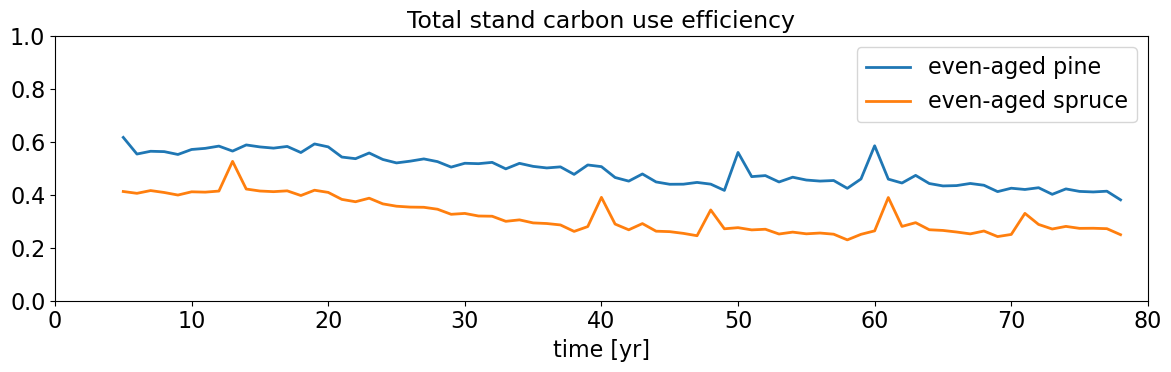

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_title("Total stand carbon use efficiency")
for sim_name in ["even-aged_pine", "even-aged_spruce"]:
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data[nr_spinup_trees:]  
    species = str(ds.species.sel(tree=tree_names[0]).data)
    
    GPP = ds.LabileC_assimilated_tree.sel(tree=tree_names).sum(dim="tree")
    Ra = ds.R_A_tree.sel(tree=tree_names).sum(dim="tree")
    Rd = ds.LabileC_respired_tree.sel(tree=tree_names).sum(dim="tree")
    CUE_with_Rd = (GPP-Ra) / (GPP+Rd)
    CUE_with_Rd[CUE_with_Rd==-np.inf] = np.nan
    
#    ax.plot(ds.time, ds.CUE, label=species)
    ax.plot(ds.time, CUE_with_Rd, label=sim_name.replace("_", " "))

#    print(sim_name, ds.CUE.mean(dim="time").data, ds.CUE.min(dim="time").data, ds.CUE.max(dim="time").data)
    print(sim_name, CUE_with_Rd.mean(dim="time").data, CUE_with_Rd.min(dim="time").data, CUE_with_Rd.max(dim="time").data)

ax.legend()
ax.set_xlim([0, 80])
ax.set_ylim([0, 1])
ax.set_xlabel("time [yr]")

fig.tight_layout()

## Trunk wood density

/home/hrme0001/anaconda3/envs/BFCPM/lib/python3.10/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/hrme0001/anaconda3/envs/BFCPM/lib/python3.10/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/hrme0001/anaconda3/envs/BFCPM/lib/python3.10/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/hrme0001/anaconda3/envs/BFCPM/lib/python3.10/site-packages/pint/facets/plain/quantity.py:986: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


even-aged_pine 481.3819387424167 kilog_dw / meter ** 3 421.60489242366737 kilog_dw / meter ** 3 545.4994213394381 kilog_dw / meter ** 3
even-aged_spruce 384.54181180536403 kilog_dw / meter ** 3 325.0837399664143 kilog_dw / meter ** 3 537.7978625314095 kilog_dw / meter ** 3


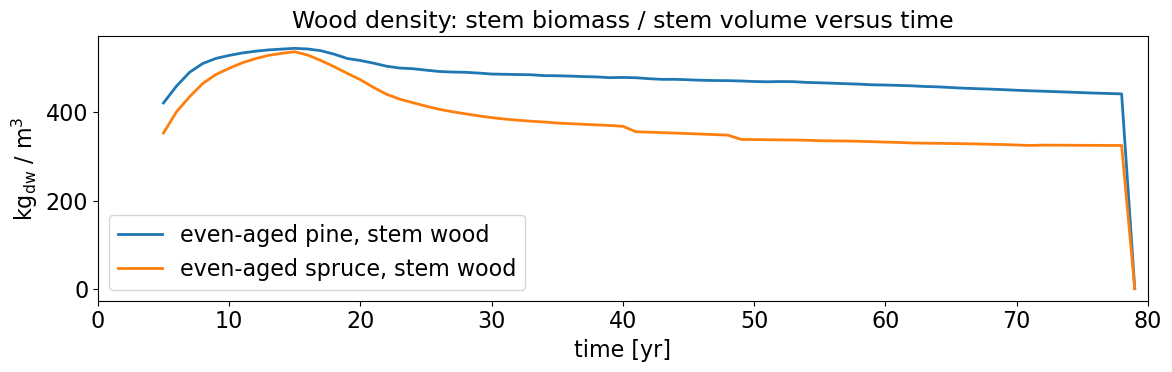

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))

sim_names_tmp = ["even-aged_pine", "even-aged_spruce"]

ax.set_title("Wood density: stem biomass / stem volume versus time")

for sim_name in sim_names_tmp:
    ds = dss[sim_name]
    tree_names = ds.entity.isel(entity=ds.tree_entity_nrs).data[nr_spinup_trees:]
    
    V_TS_single_tree = ds.V_TS_single_tree.sel(tree=tree_names)
    V_TS_single_tree = Q_(V_TS_single_tree.data, V_TS_single_tree.attrs["units"])

    V_TH_single_tree = ds.V_TH_single_tree.sel(tree=tree_names)
    V_TH_single_tree = Q_(V_TH_single_tree.data, V_TH_single_tree.attrs["units"])
    
    V_T_single_tree = V_TS_single_tree + V_TH_single_tree
    
    B_TH = ds.stocks.sel(entity=tree_names, pool="B_TH")
    B_TH = Q_(B_TH.data, B_TH.attrs["units"])
    B_TS = ds.stocks.sel(entity=tree_names, pool="B_TS")
    B_TS = Q_(B_TS.data, B_TS.attrs["units"])

    B_OS = ds.stocks.sel(entity=tree_names, pool="B_OS")
    B_OS = Q_(B_OS.data, B_OS.attrs["units"])
    C_S = ds.stocks.sel(entity=tree_names, pool="C_S")
    C_S = Q_(C_S.data, C_S.attrs["units"])
    C_TS = B_TS / (B_OS + B_TS) * C_S
    
    N_per_m2 = ds.N_per_m2.sel(tree=tree_names)
    N_per_m2 = Q_(N_per_m2.data, N_per_m2.attrs["units"])
    
    # to go to the single tree
    B_TH = B_TH / N_per_m2
    B_TS = B_TS / N_per_m2
    C_TS = C_TS / N_per_m2
    
    # multiply by 2 because the density is in g_dw / m^2 not in gC / m^2
    B_TS = B_TS.to("kg_dw")
    B_TH = B_TH.to("kg_dw")
    C_TS = C_TS.to("kg_dw")
    
    times = ds.time
    y = (B_TS + B_TH + C_TS) / V_T_single_tree
    y = np.nansum(y * N_per_m2, axis=0) / np.nansum(N_per_m2, axis=0)
    print(sim_name, np.nanmean(y[:-2]), np.nanmin(y[:-2]), np.nanmax(y))
    l, = ax.plot(times, y, label=f"{sim_name.replace('_', ' ')}, stem wood")
        
ax.legend()
ax.set_xlim([times[0], times[-1]])
ax.set_ylabel("kg$_{\mathrm{dw}}$ / m$^3$")
ax.set_xlabel(f"time [yr]")

fig.tight_layout()

# Mixed-aged pine simulations (different Ns)

## Load available simulations

In [55]:
dss = dict()
dmrs = dict()
dmrs_eq = dict()
dss_long = dict()

dss_benchmarking = dict()

In [56]:
sim_names = list()
for p in sim_cohort_path.iterdir():
    if (p.suffix == ".nc") and (str(p).find("_long") == -1) and (str(p).find("mixed-aged") != -1):
        file_sim_name = p.stem

        sim_name = file_sim_name
        print(len(sim_names), sim_name)
        sim_names.append(sim_name)
        dss[sim_name] = xr.open_dataset(str(p))
        
        dmr_path = sim_cohort_path.joinpath(p.stem + ".dmr")
        dmrs[sim_name] = DMR.load_from_file(dmr_path)
    
        dmr_eq_path = sim_cohort_path.joinpath(p.stem + ".dmr_eq")
        dmrs_eq[sim_name] = DLAPM.load_from_file(dmr_eq_path)
        
        ds_long_path = sim_cohort_path.joinpath(p.stem + "_long.nc")
        dss_long[sim_name] = xr.open_dataset(str(ds_long_path))

0 mixed-aged_pine_N1000
1 mixed-aged_pine_N1200
2 mixed-aged_pine_N1500
3 mixed-aged_pine_N2000


## Compute plot data

In [57]:
CS_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    CS = ds.CS_through_time#.isel(time=-1)
    CS = CS.data # gC/m^2 yr, CS.attrs["units"]).to("yr*kgC/m^2")
    CS_trees_and_soil = ds.CS_through_time_trees_and_soil#.isel(time=-1)
    CS_trees_and_soil = CS_trees_and_soil.data # gC/m^2 yr, CS_trees_and_soil.attrs["units"]).to("yr*kgC/m^2")
    data = np.array([CS, CS_trees_and_soil])

    CS_datas.append(data)
    
CS_datas = Q_(np.array(CS_datas).transpose(), "yr*gC/m^2").to("yr*kgC/m^2")
CS_datas.shape

(81, 2, 4)

In [58]:
yield_datas = list()
for sim_name in sim_names:
    ds = dss[sim_name]
    WPS_cum = ds.internal_fluxes.sel(pool_to="WP_S").sum(dim=["entity_to", "entity_from", "pool_from"]).cumsum(dim="time")
    WPS_cum = WPS_cum.data # gC/m^2, ds.stocks.attrs["units"])
    WPL_cum = ds.internal_fluxes.sel(pool_to="WP_L").sum(dim=["entity_to", "entity_from", "pool_from"]).cumsum(dim="time")
    WPL_cum = WPL_cum.data # gC/m^2, ds.stocks.attrs["units"])
#    print(sim_name, WPS_cum[-1])
    data = np.array([WPS_cum, WPL_cum])

    yield_datas.append(data)

yield_datas = Q_(np.array(yield_datas).transpose(), "gC/m^2").to("kgC/m^2")
yield_datas.shape

(81, 2, 4)

'/mnt/c/Users/hrme0001/GitHub/BFCPM/figs/2023-07-26/mixed-aged_pines.png'

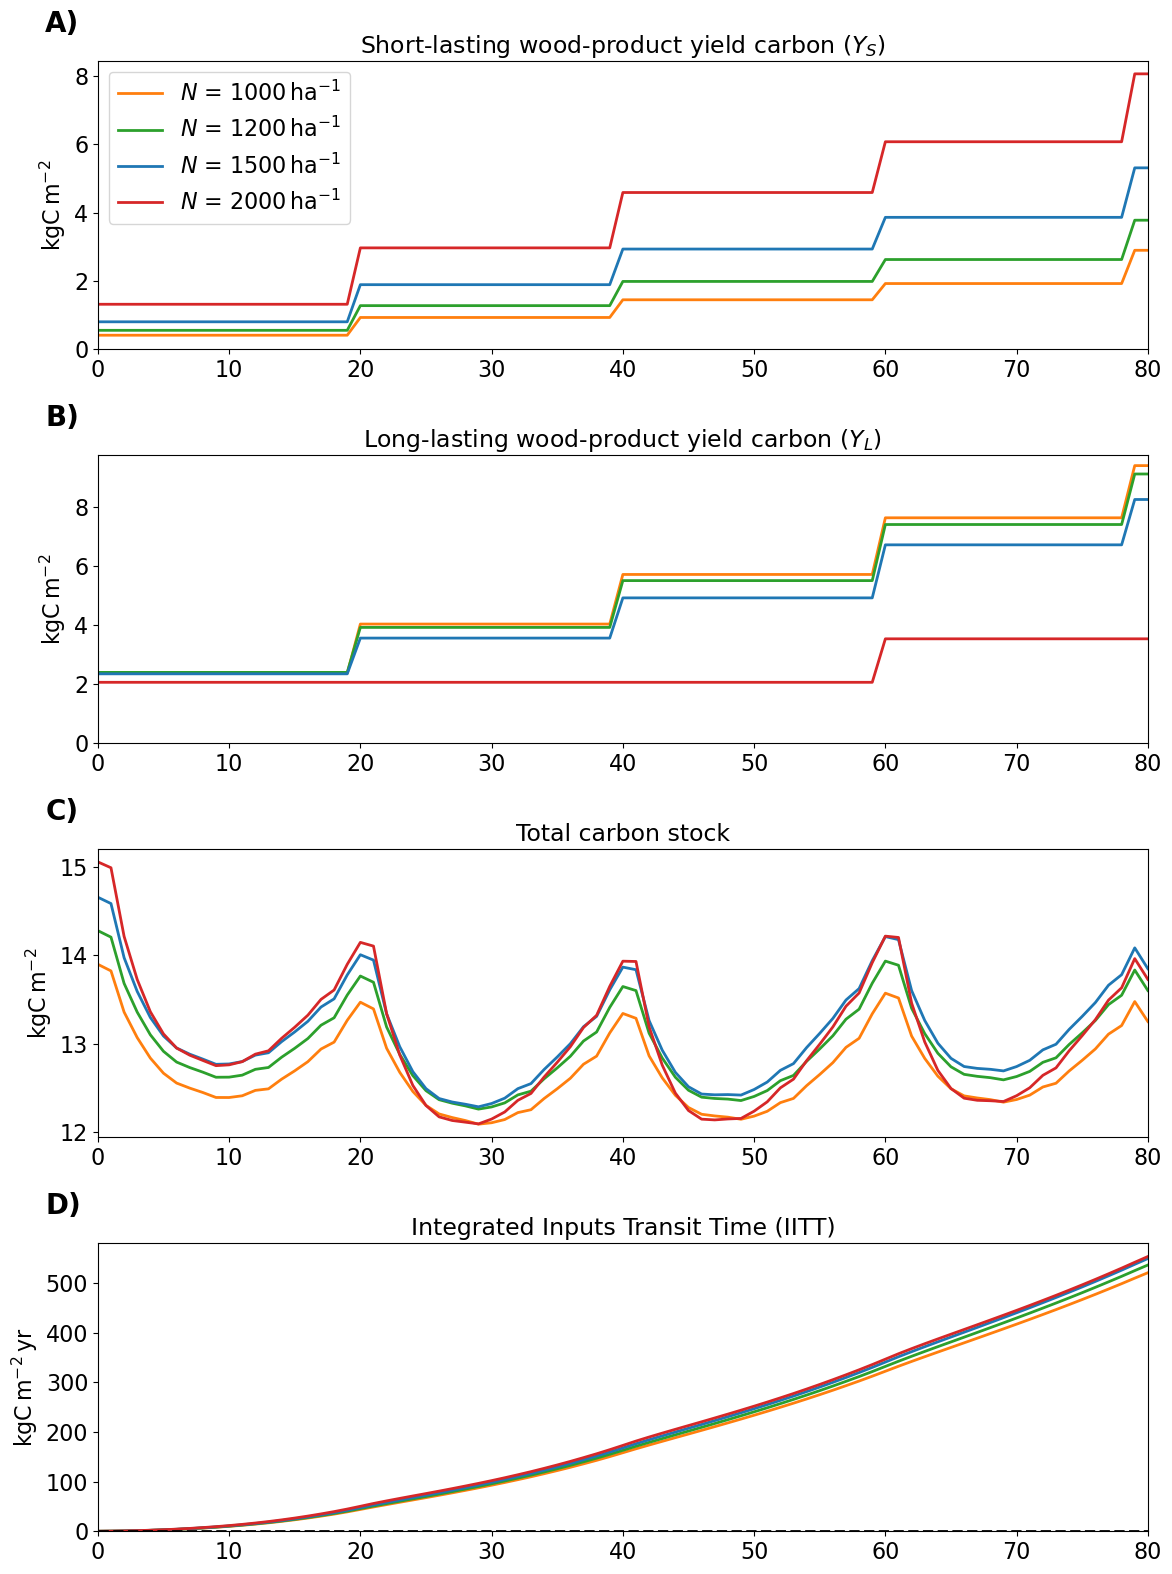

In [59]:
fig, axes = plt.subplots(figsize=(12, 4*4), nrows=4)
panel_names = iter(string.ascii_uppercase[:len(axes)])
axes = iter(axes)

base_nr = 0

colors = {sim_name: colors_list[k] for k, sim_name in enumerate([sim_names[i] for i in [2, 0, 1, 3]])}
labels = {sim_name: r"$N$ = " + f"{sim_name[-4:]}" + r"$\,$ha$^{-1}$" for sim_name in sim_names}

ax = next(axes)
panel_name = next(panel_names)
ax.set_title(r"Short-lasting wood-product yield carbon ($Y_S$)")
for nr, sim_name in enumerate(sim_names):
    l, = ax.plot(yield_datas[:, 0, nr], label=labels[sim_name], c=colors[sim_name])
    
ax.legend()
ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


ax = next(axes)
panel_name = next(panel_names)
ax.set_title(r"Long-lasting wood-product yield carbon ($Y_L$)")
for nr, sim_name in enumerate(sim_names):
    l, = ax.plot(yield_datas[:, 1, nr], c=colors[sim_name])
    
ax.set_xlim([0, 80])
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')


ax = next(axes)
panel_name = next(panel_names)
for sim_name in sim_names:
    ds = dss[sim_name]
    var = ds.total_C_stock / 1000
    var.plot(ax=ax, c=colors[sim_name])

ax.set_title("Total carbon stock")
ax.set_ylabel(r"kgC$\,$m$^{-2}$")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')
ax.set_xlim([0, 80])
ax.set_xlabel("")

    
ax = next(axes)
panel_name = next(panel_names)
ax.set_title("Integrated Inputs Transit Time (IITT)")
for nr, sim_name in enumerate(sim_names):
    ax.plot(CS_datas[:, 0, nr], c=colors[sim_name])
    
ax.axhline(0, c="black", ls="--")
ax.set_ylim([0, ax.get_ylim()[-1]])
ax.set_xlim([0, 80])
ax.set_ylabel(r"kgC$\,$m$^{-2}\,$yr")
ax.text(-0.05, 1.1, panel_name+")", transform=ax.transAxes, size=20, weight='bold')

fig.tight_layout()

# save the figure for the publication
filename = str(pub_figs_path.joinpath("mixed-aged_pines.png"))
fig.savefig(filename, dpi=500)
filename